# UCLA Scandinavian DH Seminar, November 2017

Notebook to perform text similarity calculation and clustering for seminar hackathon.

Initial work by Matthew Wilkens, November 2017.

In [95]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from   mpl_toolkits.mplot3d import Axes3D
from   nltk.corpus.reader.plaintext import PlaintextCorpusReader
from   nltk.corpus import stopwords
from   nltk.probability import FreqDist
from   collections import defaultdict
import csv
import itertools
import numpy as np
import operator
import pandas as pd
import random
from   sklearn.cluster import KMeans, DBSCAN
from   sklearn.decomposition import PCA
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics import silhouette_samples, silhouette_score
from   sklearn.metrics.pairwise import pairwise_distances
from   sklearn.preprocessing import StandardScaler
from   IPython.display import display

In [2]:
# Additional imports if processing full input texts rather than loading derived data
from   glob import glob
import shutil

In [3]:
%matplotlib inline

corpus_name  = 'ADL'
figDir       = 'figures'
resultsDir   = 'results'
dataDir      = os.path.join('..', '..', corpus_name)
metadataFile = os.path.join(dataDir, 'metadata', 'metadata_adl.csv')
corpusDir    = os.path.join(dataDir, 'plain')

sns.set()
sns.set_context('notebook')
plt.rc('figure', figsize=(12, 8))

In [4]:
metadata = pd.read_csv(metadataFile, index_col='file_id')

In [5]:
metadata.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
hjort_02_workid54087                Knud Hjortø   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
hjort_02_workid54087                                 Kraft   

                                            volume  birth  death  
file_id                                                           
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872  
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905  
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872  
plough01_workid56672                 SAMLEDE DIGTE   1813   1894  
hjort_02_workid54087                         KRAFT   1869   1931

In [6]:
metadata.describe()

birth        death
count  8787.000000  8787.000000
mean   1785.979060  1849.617048
std      89.231021    87.095092
min       0.000000     0.000000
25%    1764.000000  1826.000000
50%    1800.000000  1872.000000
75%    1863.000000  1914.000000
max    1912.000000  1938.000000

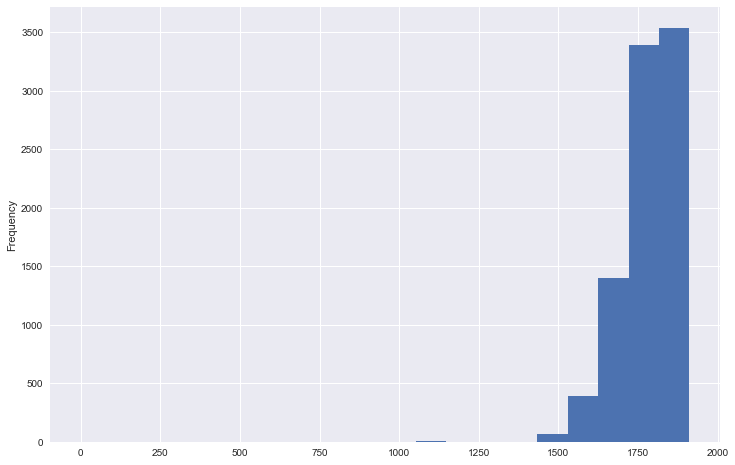

In [7]:
fig = metadata.birth.plot.hist(bins=20)

In [8]:
metadata[metadata.birth == 0]

author       title       volume  birth  death
file_id                                                               
larsenk_09_workid54089  kapitel  Lægemidler  DOMMENS DAG      0      0

In [9]:
md = metadata[metadata.birth != 0]

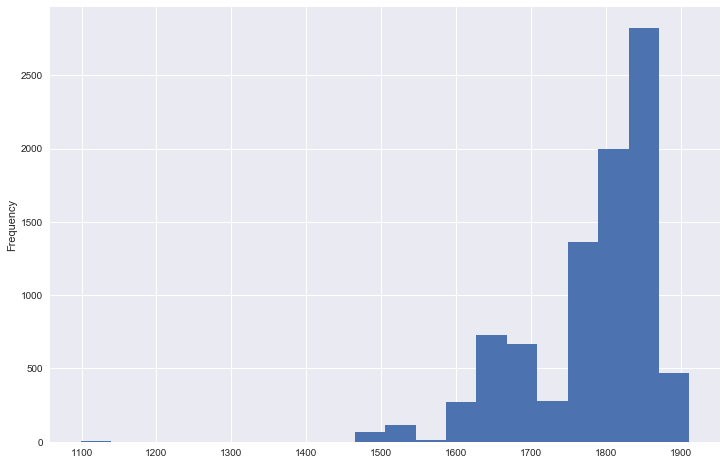

In [10]:
md.birth.plot.hist(bins=20)

In [11]:
md.author.nunique()

75

In [12]:
md.volume.nunique()

299

In [13]:
corpus = PlaintextCorpusReader(corpusDir, '.*\.txt')

In [14]:
corpus.fileids()[:5]

['Lars_workid54234.txt',
 'Lars_workid60226.txt',
 'Lars_workid63000.txt',
 'aakjaer01val_workid100074.txt',
 'aakjaer01val_workid100247.txt']

In [15]:
md[md.index == 'Lars_workid54234']

author                  title  \
file_id                                                 
Lars_workid54234   Karl Larsen  Udenfor rangklasserne   

                                   volume  birth  death  
file_id                                                  
Lars_workid54234  Københavnerfortællinger   1860   1931

In [16]:
len(corpus.words('Lars_workid54234.txt'))

35021

In [17]:
wordcounts = {}
for fileid in corpus.fileids():
    wordcounts[fileid.strip('.txt')] = len(corpus.words(fileid))
md = md.join(pd.Series(wordcounts, name='wordcount'))

In [18]:
md.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
hjort_02_workid54087                Knud Hjortø   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
hjort_02_workid54087                                 Kraft   

                                            volume  birth  death  wordcount  
file_id                                                                      
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0  
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0  
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0  
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0  
hjort_02_workid54087                         KRAFT   1869   1931    66532.0

In [19]:
md[md.wordcount.isnull()].count()

author       30
title        22
volume       30
birth        30
death        30
wordcount     0
dtype: int64

In [20]:
md[md.wordcount > 100000].sort_values('wordcount', ascending=False)

author  \
file_id                                                  
saxoval_workid54112                               Saxo   
bergsoev01ny_workid54112               Vilhelm Bergsøe   
grundtvig06val_workid54333            N.F.S. Grundtvig   
ingemann02_workid54477                   B.S. Ingemann   
kierkegaard03val_workid54108         Søren Kierkegaard   
holberg13val_workid54110                Ludvig Holberg   
kidde04ny_workid54108                     Harald Kidde   
heibfr01_workid54096             Johanne Luise Heiberg   
schandorph04_workid54192             Sophus Schandorph   
grundtvig05val_workid110911           N.F.S. Grundtvig   
grundtvig07val_workid54323            N.F.S. Grundtvig   
kidde03_workid54091                       Harald Kidde   
bergsoe02_workid54211                  Vilhelm Bergsøe   
larsenk_11_workid54089                     Karl Larsen   
heibergpa01val_workid54805       Peter Andreas Heiberg   
holberg01val_workid57612                Ludvig Holberg   
drachmann14val_workid54224            Holger Drachmann   
heibfr04_workid54097             Johanne Luise Heiberg   
brandes06_workid54311                   Edvard Brandes   
grundtvig07val_workid185972           N.F.S. Grundtvig   
andersen03val_workid54101      Hans Christian Andersen   
brandes06_workid78618                   Edvard Brandes   
kidde02val_workid54322                    Harald Kidde   
grundtvig08val_workid165964           N.F.S. Grundtvig   
brandes05_workid73502                   Edvard Brandes   
goldschmidt04_workid54420        Meir Aron Goldschmidt   
andersen05val_workid54101      Hans Christian Andersen   
grundtvig10val_workid70584            N.F.S. Grundtvig   
dalgasdomval_workid54438                Ernesto Dalgas   
andersen02val_workid54459      Hans Christian Andersen   
schackval_workid54353                Hans Egede Schack   
heibfr02_workid54097             Johanne Luise Heiberg   
grundtvig09val_workid130854           N.F.S. Grundtvig   
grundtvig11val_workid57825            N.F.S. Grundtvig   
baggesen06_workid54102                   Jens Baggesen   
heibfr03_workid54099             Johanne Luise Heiberg   
aakjaer06val_workid64877                  Jeppe Aakjær   
brandes04_workid66532                   Edvard Brandes   
bang07val_workid54099                      Herman Bang   
gjellerup03_workid54091                 Karl Gjellerup   
grundtvig02val_workid77758            N.F.S. Grundtvig   
kingo04val_workid54714                    Thomas Kingo   
dalgaslideval_workid53744               Ernesto Dalgas   
andersen07val_workid54108      Hans Christian Andersen   
drachmann13val_workid54108            Holger Drachmann   
hjort_13_workid54096                       Knud Hjortø   
goldschmidt02t_workid54998       Meir Aron Goldschmidt   
falster01_workid55655                Christian Falster   
kidde01val_workid54320                    Harald Kidde   
jacobjp07val_workid54105                 J.P. Jacobsen   
bang09val_workid54102                      Herman Bang   
brandes05_workid54333                   Edvard Brandes   
heibfr06val_workid54580          Johanne Luise Heiberg   
schandorph06_workid73597             Sophus Schandorph   
andersen04val_workid54102      Hans Christian Andersen   
andersenhc_09_workid54101      Hans Christian Andersen   
gjellerup01_workid54089                 Karl Gjellerup   
schandorph06_workid54195             Sophus Schandorph   
grundtvig04val_workid126922           N.F.S. Grundtvig   
schandorph05_workid68556             Sophus Schandorph   

                                                                          title  \
file_id                                                                           
saxoval_workid54112                                   Fra piazza del popolo · i   
bergsoev01ny_workid54112                              Fra piazza del popolo · i   
grundtvig06val_workid54333       Hovedstrømninger. reaktionen i frankrig (1874)   
ingemann02_workid54477              

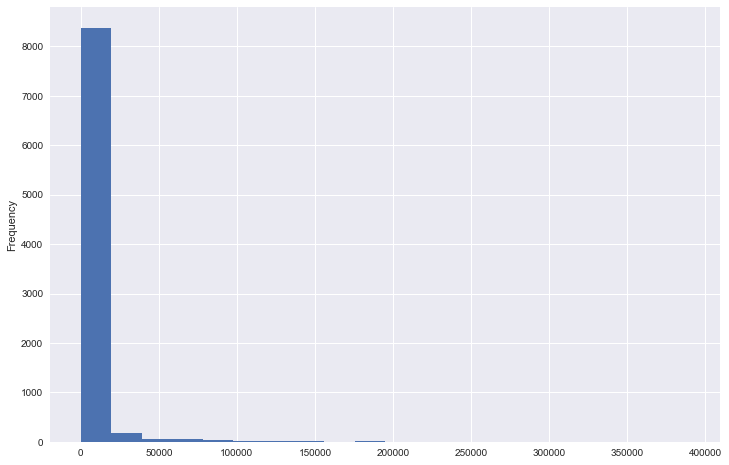

In [21]:
md.wordcount.plot.hist(bins=20)

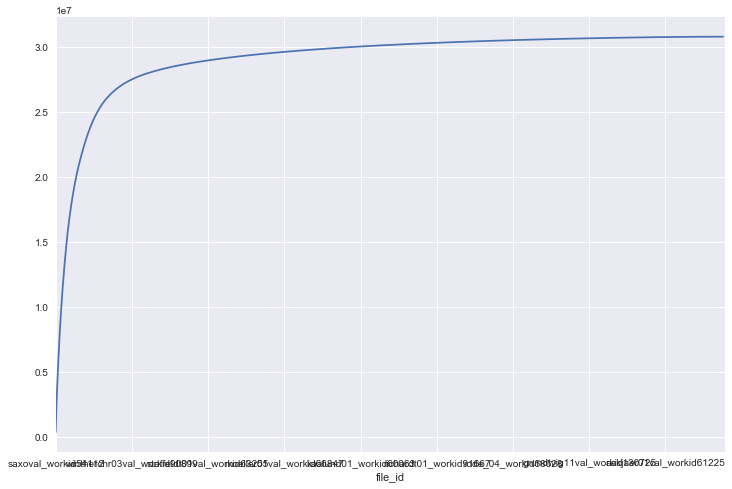

In [22]:
md.wordcount.sort_values(ascending=False).cumsum().plot()

In [23]:
md[md.wordcount >= 10000].wordcount.count()

568

In [24]:
ws = md[md.wordcount.between(100,10000)]

In [25]:
ws.describe()

birth       death    wordcount
count  6837.000000  6837.00000  6837.000000
mean   1782.158842  1846.98669   805.230657
std      84.719538    83.77847  1356.886230
min    1485.000000  1534.00000   100.000000
25%    1743.000000  1785.00000   192.000000
50%    1798.000000  1872.00000   339.000000
75%    1861.000000  1908.00000   722.000000
max    1912.000000  1938.00000  9999.000000

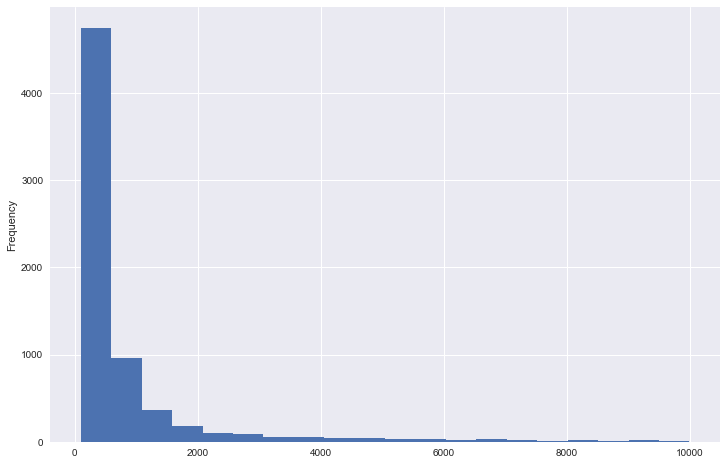

In [26]:
ws.wordcount.plot.hist(bins=20)

In [27]:
print("Total volumes with wordcount > 100 =", md.wordcount.count(), 
      "containing", md.wordcount.sum(), "words")
print("Total volumes in restricted workset = ", ws.wordcount.count(), 
      "containing", ws.wordcount.sum(), "words")

Total volumes with wordcount > 100 = 8756 containing 30820704.0 words
Total volumes in restricted workset =  6837 containing 5505362.0 words


We currently throw out long documents (over 10k), since they're likely very different from most in the corpus. But know that that throws away most of the text (31M -> 5.5M words). Something to examine on site.

In [131]:
ws.to_csv(os.path.join(resultsDir, 'workset.csv'))

In [28]:
sw = set(stopwords.words('danish'))

In [29]:
len(sw)

94

In [30]:
%%time
# Get stopword count in full corpus
stopped = defaultdict(int)
for w in corpus.words():
    if w in sw:
        stopped[w] += 1

CPU times: user 25.2 s, sys: 861 ms, total: 26.1 s
Wall time: 26.6 s


In [31]:
print(stopped)

defaultdict(<class 'int'>, {'i': 520741, 'og': 815012, 'men': 116735, 'har': 132739, 'nogle': 10869, 'med': 257874, 'af': 260482, 'den': 342945, 'er': 300627, 'over': 67611, 'til': 307934, 'for': 218832, 'han': 261770, 'ikke': 229538, 'være': 52852, 'en': 345866, 'det': 420806, 'været': 21378, 'min': 73177, 'om': 143546, 'jeg': 265219, 'du': 65268, 'mig': 136022, 'ud': 57376, 'alle': 48269, 'din': 26501, 'eller': 54391, 'dem': 58570, 'ad': 16707, 'der': 213732, 'som': 302175, 'at': 474818, 'ham': 103111, 'jo': 42656, 'nu': 76291, 'dig': 34658, 'hvor': 53897, 'de': 225772, 'op': 48440, 'var': 248240, 'efter': 47536, 'hvad': 56041, 'vi': 74163, 'et': 153602, 'fra': 89909, 'ind': 40719, 'da': 97345, 'man': 61820, 'her': 42040, 'os': 40983, 'hun': 117050, 'hende': 44897, 'hendes': 32505, 'blev': 54656, 'mit': 28086, 'mange': 19418, 'denne': 43284, 'ned': 28856, 'meget': 29649, 'end': 49714, 'noget': 34719, 'hans': 80107, 'sig': 175522, 'selv': 57155, 'vil': 61783, 'mine': 17201, 'sine': 28

## Gensim

See also https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/lda_training_tips.ipynb, from which much code below taken.

In [47]:
import gensim
import pyLDAvis.gensim
from gensim.models import LdaModel

In [33]:
pyLDAvis.enable_notebook()

In [90]:
docs = []
labels = []
for fid in ws.index:
    with open(os.path.join(corpusDir, fid+'.txt')) as f:
        txt = f.read()
    docs.append(txt)
    labels.append(fid)

In [91]:
print("Documents to process:", len(docs))

Documents to process: 6837


In [92]:
docs[0]

'No. 196.\n*)Jeg som et Barn mig glæde vil,Og sjunge i det Høie:Idag ei Sorg paa Jord er til,Som kan min Sjæl nedbøie!Idag er fattigst Betler rig!Et Paradis er Jorden mig,Guds Engle til mig kvæde:Idag er dig en Frelser fød!Idag al Jordens Sorg er død,Og født al Jordens Glæde!Ei Synd og Død i Verden meerMig knuge skal og kyse:Jeg Naadens Sol oprundet seer,Og den skal evig lyse!En Konge er idag mig fød:Det lidet Barn paa Moders SkiødAl Verdens Nød betvinger!Hans Rige Himmel er og Jord;*)\n                        Ingemanns Jule-Sang\nmed et Par Smaa-Ændringer.Den Konge evig Tro jeg svor,Og Han min Sjæl gav Vinger!Flyv høit, min Sjæl, da barnefro!Forlyst dig i Hans Rige,Med Kiærlighed, med Haab og Tro!Hans Ord skal aldrig svige!I Klude svøbt, i Krybbe lagt,Det Barn har over Stormen Magt,Og over Havets Bølger;Ei Jord, ei\n                           Luft\n, ei\n                           Ild\n, ei Vand,Ei Mørkets Magter skade kanDen Sjæl, som Barnet følger!Ei Verdens Glands og Klogskab meerF

In [93]:
# Tokenize, converting to lowercase
#  Also, remove line breaks, numbers, and one-letter words

from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
docs_tokenized = docs

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [94]:
docs_tokenized[0]

['no',
 'jeg',
 'som',
 'et',
 'barn',
 'mig',
 'glæde',
 'vil',
 'og',
 'sjunge',
 'i',
 'det',
 'høie',
 'idag',
 'ei',
 'sorg',
 'paa',
 'jord',
 'er',
 'til',
 'som',
 'kan',
 'min',
 'sjæl',
 'nedbøie',
 'idag',
 'er',
 'fattigst',
 'betler',
 'rig',
 'et',
 'paradis',
 'er',
 'jorden',
 'mig',
 'guds',
 'engle',
 'til',
 'mig',
 'kvæde',
 'idag',
 'er',
 'dig',
 'en',
 'frelser',
 'fød',
 'idag',
 'al',
 'jordens',
 'sorg',
 'er',
 'død',
 'og',
 'født',
 'al',
 'jordens',
 'glæde',
 'ei',
 'synd',
 'og',
 'død',
 'i',
 'verden',
 'meermig',
 'knuge',
 'skal',
 'og',
 'kyse',
 'jeg',
 'naadens',
 'sol',
 'oprundet',
 'seer',
 'og',
 'den',
 'skal',
 'evig',
 'lyse',
 'en',
 'konge',
 'er',
 'idag',
 'mig',
 'fød',
 'det',
 'lidet',
 'barn',
 'paa',
 'moders',
 'skiødal',
 'verdens',
 'nød',
 'betvinger',
 'hans',
 'rige',
 'himmel',
 'er',
 'og',
 'jord',
 'ingemanns',
 'jule',
 'sang',
 'med',
 'et',
 'par',
 'smaa',
 'ændringer',
 'den',
 'konge',
 'evig',
 'tro',
 'jeg',
 'svo

In [38]:
%%time
# Stem. Would like to lemmatuze, but no Danish support
from nltk.stem.snowball import DanishStemmer

# Lemmatize all words in documents.
stemmer = DanishStemmer()
docs = [[stemmer.stem(token) for token in doc] for doc in docs]

In [39]:
len(docs[0])

265

In [40]:
# Compute bigrams.

from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [41]:
len(docs[0])

271

In [42]:
# Remove rare and common tokens.
# B/c we remove common tokens, no need for explicit list of stopwords.

from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur in fewer than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [43]:
# Vectorize data.

# Bag-of-words representation of the documents.
gs_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [44]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(gs_corpus))

Number of unique tokens: 23647
Number of documents: 6837


In [45]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [51]:
# Train LDA model.
# Set training parameters.
num_topics = 100
chunksize = 10000
passes = 100 # Probably higher than necessary. Get away with 30? 100 takes about 45-60 min.
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
random_state = 4365

# Make an index-to-word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [58]:
%time model = LdaModel(corpus=gs_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=random_state, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

2017-11-09 20:58:24,611 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2017-11-09 20:58:24,620 : INFO : using serial LDA version on this node
2017-11-09 20:58:38,232 : INFO : running online (multi-pass) LDA training, 100 topics, 100 passes over the supplied corpus of 6837 documents, updating model once every 6837 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence

2017-11-09 21:02:07,964 : INFO : topic #85 (0.009): 0.039*"hallo" + 0.008*"vi" + 0.007*"mod" + 0.007*"kong" + 0.006*"balthasar" + 0.005*"babylon" + 0.005*"rid" + 0.005*"vild" + 0.005*"vort" + 0.005*"sand"
2017-11-09 21:02:07,965 : INFO : topic #84 (0.009): 0.027*"hand" + 0.008*"gud" + 0.007*"och" + 0.006*"forgjæv" + 0.006*"vel" + 0.005*"sit" + 0.005*"end" + 0.005*"ja" + 0.005*"ven" + 0.005*"mand"
2017-11-09 21:02:07,968 : INFO : topic #91 (0.011): 0.012*"dig" + 0.011*"vi" + 0.008*"oc" + 0.007*"hvad" + 0.007*"vor" + 0.006*"end" + 0.005*"ei" + 0.005*"ikk" + 0.005*"os" + 0.005*"gud"
2017-11-09 21:02:07,970 : INFO : topic #76 (0.011): 0.010*"dig" + 0.009*"mod" + 0.009*"sol" + 0.008*"ej" + 0.007*"mit" + 0.006*"dit" + 0.006*"over" + 0.006*"skov" + 0.006*"jord" + 0.005*"nat"
2017-11-09 21:02:07,973 : INFO : topic #49 (0.011): 0.009*"liv" + 0.006*"mod" + 0.006*"kun" + 0.006*"vi" + 0.005*"ham" + 0.005*"hvad" + 0.005*"kan" + 0.005*"ikk" + 0.005*"blev" + 0.005*"død"
2017-11-09 21:02:07,986 : INFO

2017-11-09 21:03:52,290 : INFO : topic #84 (0.008): 0.020*"hand" + 0.010*"forgjæv" + 0.008*"etc" + 0.005*"lyksa" + 0.005*"amaryllis" + 0.005*"gud" + 0.005*"find" + 0.005*"pris" + 0.005*"sit" + 0.005*"ja"
2017-11-09 21:03:52,292 : INFO : topic #45 (0.008): 0.011*"ham" + 0.010*"vi" + 0.008*"ei" + 0.008*"ja" + 0.007*"kan" + 0.007*"os" + 0.007*"kain" + 0.006*"hvad" + 0.005*"konst" + 0.005*"folk"
2017-11-09 21:03:52,294 : INFO : topic #23 (0.012): 0.025*"gud" + 0.023*"os" + 0.019*"vi" + 0.018*"vor" + 0.017*"ei" + 0.014*"aand" + 0.014*"ord" + 0.012*"hjert" + 0.011*"liv" + 0.010*"kun"
2017-11-09 21:03:52,296 : INFO : topic #49 (0.012): 0.010*"liv" + 0.007*"mod" + 0.006*"ej" + 0.006*"kun" + 0.006*"vi" + 0.005*"ham" + 0.005*"hvad" + 0.005*"kan" + 0.005*"død" + 0.005*"blev"
2017-11-09 21:03:52,299 : INFO : topic #76 (0.014): 0.010*"mod" + 0.009*"dig" + 0.009*"sol" + 0.009*"ej" + 0.007*"over" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.005*"jord" + 0.005*"lys"
2017-11-09 21:03:52,312 : INFO : 

2017-11-09 21:05:28,071 : INFO : topic #85 (0.008): 0.039*"hallo" + 0.009*"babylon" + 0.006*"mod" + 0.006*"balthasar" + 0.005*"rid" + 0.005*"kong" + 0.004*"vild" + 0.004*"vi" + 0.004*"kom" + 0.003*"vort"
2017-11-09 21:05:28,073 : INFO : topic #84 (0.008): 0.014*"hand" + 0.011*"forgjæv" + 0.009*"etc" + 0.006*"amaryllis" + 0.005*"lyksa" + 0.005*"find" + 0.005*"pris" + 0.005*"sit" + 0.005*"mag" + 0.004*"rank"
2017-11-09 21:05:28,075 : INFO : topic #49 (0.013): 0.010*"liv" + 0.008*"ej" + 0.007*"mod" + 0.007*"kun" + 0.005*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"kan"
2017-11-09 21:05:28,077 : INFO : topic #23 (0.013): 0.027*"gud" + 0.021*"os" + 0.017*"vi" + 0.016*"vor" + 0.016*"ei" + 0.015*"aand" + 0.014*"ord" + 0.012*"hjert" + 0.011*"liv" + 0.010*"kun"
2017-11-09 21:05:28,080 : INFO : topic #76 (0.017): 0.010*"mod" + 0.010*"sol" + 0.009*"dig" + 0.008*"ej" + 0.008*"over" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.006*"lys" + 0.005*"jord"
2017-11-09 21:05

2017-11-09 21:07:00,541 : INFO : topic #85 (0.008): 0.036*"hallo" + 0.008*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"rid" + 0.004*"kong" + 0.004*"vild" + 0.004*"kom" + 0.003*"øs" + 0.003*"mand"
2017-11-09 21:07:00,544 : INFO : topic #45 (0.008): 0.011*"ham" + 0.010*"kain" + 0.009*"abel" + 0.008*"ja" + 0.006*"konst" + 0.006*"ei" + 0.006*"kan" + 0.005*"vi" + 0.005*"hvad" + 0.004*"folk"
2017-11-09 21:07:00,546 : INFO : topic #49 (0.014): 0.010*"liv" + 0.009*"ej" + 0.007*"mod" + 0.007*"kun" + 0.005*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"kan"
2017-11-09 21:07:00,549 : INFO : topic #23 (0.014): 0.028*"gud" + 0.019*"os" + 0.016*"ei" + 0.015*"vor" + 0.015*"vi" + 0.014*"ord" + 0.014*"aand" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:07:00,551 : INFO : topic #76 (0.020): 0.010*"mod" + 0.010*"sol" + 0.009*"dig" + 0.008*"over" + 0.008*"ej" + 0.007*"mit" + 0.006*"dit" + 0.006*"skov" + 0.006*"lys" + 0.005*"jord"
2017-11-09 21:07:00,564 : INF

2017-11-09 21:08:31,704 : INFO : topic #85 (0.008): 0.033*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"rid" + 0.004*"vild" + 0.004*"kong" + 0.004*"kom" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:08:31,706 : INFO : topic #84 (0.008): 0.011*"forgjæv" + 0.009*"etc" + 0.008*"hand" + 0.006*"amaryllis" + 0.005*"lyksa" + 0.005*"find" + 0.005*"mir" + 0.004*"mag" + 0.004*"rank" + 0.004*"pris"
2017-11-09 21:08:31,708 : INFO : topic #49 (0.015): 0.010*"liv" + 0.010*"ej" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"død" + 0.005*"blev" + 0.005*"tid"
2017-11-09 21:08:31,710 : INFO : topic #23 (0.015): 0.028*"gud" + 0.017*"os" + 0.016*"ei" + 0.015*"ord" + 0.014*"vor" + 0.014*"aand" + 0.013*"vi" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:08:31,713 : INFO : topic #76 (0.024): 0.010*"sol" + 0.010*"mod" + 0.009*"dig" + 0.008*"over" + 0.008*"ej" + 0.007*"mit" + 0.006*"lys" + 0.006*"dit" + 0.006*"skov" + 0.006*"jord"
2017-11-09 21:0

2017-11-09 21:10:01,385 : INFO : topic #84 (0.007): 0.010*"forgjæv" + 0.008*"etc" + 0.006*"hand" + 0.006*"amaryllis" + 0.005*"mir" + 0.005*"find" + 0.005*"lyksa" + 0.004*"mag" + 0.004*"sit" + 0.004*"rank"
2017-11-09 21:10:01,387 : INFO : topic #85 (0.007): 0.031*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.005*"balthasar" + 0.004*"kom" + 0.004*"vild" + 0.004*"rid" + 0.004*"kong" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:10:01,390 : INFO : topic #49 (0.016): 0.011*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"blev" + 0.005*"død" + 0.005*"tid"
2017-11-09 21:10:01,393 : INFO : topic #23 (0.016): 0.028*"gud" + 0.016*"os" + 0.016*"ei" + 0.015*"ord" + 0.014*"aand" + 0.014*"vor" + 0.012*"vi" + 0.012*"hjert" + 0.011*"liv" + 0.009*"kun"
2017-11-09 21:10:01,395 : INFO : topic #76 (0.027): 0.010*"sol" + 0.010*"mod" + 0.009*"dig" + 0.008*"over" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:10

2017-11-09 21:11:31,397 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.005*"mir" + 0.004*"hand" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"mag" + 0.004*"rank"
2017-11-09 21:11:31,399 : INFO : topic #85 (0.007): 0.029*"hallo" + 0.007*"babylon" + 0.006*"mod" + 0.004*"balthasar" + 0.004*"kom" + 0.004*"vild" + 0.004*"kong" + 0.004*"rid" + 0.003*"mand" + 0.003*"nat"
2017-11-09 21:11:31,401 : INFO : topic #49 (0.017): 0.011*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"blev" + 0.005*"tid" + 0.005*"død"
2017-11-09 21:11:31,403 : INFO : topic #23 (0.017): 0.028*"gud" + 0.016*"ei" + 0.016*"os" + 0.015*"ord" + 0.014*"aand" + 0.013*"vor" + 0.012*"hjert" + 0.011*"vi" + 0.011*"liv" + 0.009*"død"
2017-11-09 21:11:31,406 : INFO : topic #76 (0.030): 0.010*"sol" + 0.010*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:11

2017-11-09 21:12:59,357 : INFO : topic #85 (0.007): 0.028*"hallo" + 0.006*"babylon" + 0.006*"mod" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.004*"kong" + 0.004*"rid" + 0.003*"mand" + 0.003*"vi"
2017-11-09 21:12:59,359 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"ikk" + 0.004*"mag" + 0.004*"man"
2017-11-09 21:12:59,362 : INFO : topic #23 (0.018): 0.028*"gud" + 0.016*"ei" + 0.015*"os" + 0.015*"ord" + 0.014*"aand" + 0.012*"vor" + 0.012*"hjert" + 0.011*"liv" + 0.010*"vi" + 0.009*"død"
2017-11-09 21:12:59,365 : INFO : topic #49 (0.018): 0.012*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"død"
2017-11-09 21:12:59,367 : INFO : topic #76 (0.033): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.007*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"dit" + 0.006*"jord"
2017-11-09 21:12:59

2017-11-09 21:14:28,334 : INFO : topic #85 (0.007): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.004*"kong" + 0.003*"rid" + 0.003*"mand" + 0.003*"vi"
2017-11-09 21:14:28,337 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"ikk" + 0.004*"sit" + 0.004*"man" + 0.004*"mag"
2017-11-09 21:14:28,340 : INFO : topic #23 (0.019): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.014*"os" + 0.013*"aand" + 0.012*"vor" + 0.012*"hjert" + 0.011*"liv" + 0.010*"død" + 0.010*"vi"
2017-11-09 21:14:28,342 : INFO : topic #49 (0.019): 0.012*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:14:28,344 : INFO : topic #76 (0.036): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:14:28

2017-11-09 21:15:55,544 : INFO : topic #85 (0.007): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand" + 0.003*"ikk"
2017-11-09 21:15:55,546 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"ikk" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"man" + 0.004*"mag"
2017-11-09 21:15:55,548 : INFO : topic #23 (0.020): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.014*"os" + 0.013*"aand" + 0.012*"hjert" + 0.012*"vor" + 0.011*"liv" + 0.010*"død" + 0.009*"kun"
2017-11-09 21:15:55,551 : INFO : topic #49 (0.021): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:15:55,553 : INFO : topic #76 (0.039): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"ej" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:15:

2017-11-09 21:17:22,245 : INFO : topic #84 (0.007): 0.009*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"find" + 0.004*"mir" + 0.004*"ikk" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"man" + 0.004*"dem"
2017-11-09 21:17:22,247 : INFO : topic #85 (0.007): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:17:22,249 : INFO : topic #23 (0.020): 0.028*"gud" + 0.016*"ei" + 0.015*"ord" + 0.013*"aand" + 0.013*"os" + 0.012*"hjert" + 0.011*"vor" + 0.011*"liv" + 0.010*"død" + 0.009*"kun"
2017-11-09 21:17:22,251 : INFO : topic #49 (0.022): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:17:22,254 : INFO : topic #76 (0.041): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"ej" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:17:

2017-11-09 21:18:48,822 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:18:48,824 : INFO : topic #45 (0.007): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"konst" + 0.005*"ikk" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kan"
2017-11-09 21:18:48,826 : INFO : topic #68 (0.021): 0.197*"vi" + 0.083*"vor" + 0.074*"os" + 0.031*"vort" + 0.007*"land" + 0.006*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"kun"
2017-11-09 21:18:48,828 : INFO : topic #49 (0.023): 0.013*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"blev" + 0.005*"end"
2017-11-09 21:18:48,831 : INFO : topic #76 (0.044): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"ej" + 0.006*"jord" + 0.006*"dit"
2017-11-09 21:18:48,843 : I

2017-11-09 21:20:15,474 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:20:15,476 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.004*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"man"
2017-11-09 21:20:15,478 : INFO : topic #68 (0.022): 0.199*"vi" + 0.085*"vor" + 0.076*"os" + 0.031*"vort" + 0.007*"land" + 0.006*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.004*"kun"
2017-11-09 21:20:15,480 : INFO : topic #49 (0.024): 0.014*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"blev"
2017-11-09 21:20:15,482 : INFO : topic #76 (0.046): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"ej" + 0.006*"dit"
2017-11-09 21:20:1

2017-11-09 21:21:41,800 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"rid" + 0.003*"ikk" + 0.003*"mand"
2017-11-09 21:21:41,802 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:21:41,805 : INFO : topic #68 (0.024): 0.202*"vi" + 0.086*"vor" + 0.078*"os" + 0.032*"vort" + 0.007*"land" + 0.007*"lad" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:21:41,809 : INFO : topic #49 (0.025): 0.014*"ej" + 0.010*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"blev"
2017-11-09 21:21:41,811 : INFO : topic #76 (0.048): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"ej" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:23:06,588 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:23:06,590 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:23:06,592 : INFO : topic #68 (0.025): 0.204*"vi" + 0.088*"vor" + 0.080*"os" + 0.032*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:23:06,595 : INFO : topic #49 (0.026): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:23:06,597 : INFO : topic #76 (0.050): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit" + 0.005*"nat"
2017-11-09 21:23:06,612 

2017-11-09 21:24:32,377 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:24:32,379 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:24:32,381 : INFO : topic #68 (0.026): 0.207*"vi" + 0.089*"vor" + 0.082*"os" + 0.032*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:24:32,384 : INFO : topic #49 (0.027): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:24:32,386 : INFO : topic #76 (0.051): 0.010*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"dit" + 0.006*"nat"
2017-11-09 21:24:32,399 

2017-11-09 21:25:58,265 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"kong" + 0.003*"ikk" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:25:58,267 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:25:58,269 : INFO : topic #68 (0.027): 0.209*"vi" + 0.090*"vor" + 0.083*"os" + 0.033*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"mod" + 0.005*"kan" + 0.005*"lad_os"
2017-11-09 21:25:58,271 : INFO : topic #49 (0.028): 0.014*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:25:58,273 : INFO : topic #76 (0.053): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:25:58,285 

2017-11-09 21:27:23,235 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:27:23,237 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.004*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:27:23,240 : INFO : topic #68 (0.029): 0.211*"vi" + 0.091*"vor" + 0.085*"os" + 0.033*"vort" + 0.007*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"lad_os" + 0.005*"mod" + 0.005*"kan"
2017-11-09 21:27:23,242 : INFO : topic #49 (0.029): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:27:23,244 : INFO : topic #76 (0.055): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:28:49,062 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:28:49,064 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:28:49,066 : INFO : topic #68 (0.030): 0.212*"vi" + 0.092*"vor" + 0.086*"os" + 0.033*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"maa" + 0.005*"lad_os" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:28:49,068 : INFO : topic #49 (0.030): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:28:49,070 : INFO : topic #76 (0.056): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:2

2017-11-09 21:30:13,919 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:30:13,923 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:30:13,927 : INFO : topic #49 (0.031): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:30:13,931 : INFO : topic #68 (0.031): 0.214*"vi" + 0.093*"vor" + 0.087*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.005*"maa" + 0.005*"lad_os" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:30:13,933 : INFO : topic #76 (0.057): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dit"
2017-11-09 21:3

2017-11-09 21:31:48,566 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:31:48,568 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:31:48,570 : INFO : topic #49 (0.032): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"end" + 0.005*"kan"
2017-11-09 21:31:48,572 : INFO : topic #68 (0.032): 0.216*"vi" + 0.094*"vor" + 0.089*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:31:48,574 : INFO : topic #76 (0.058): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"dig" + 0.008*"mit" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:33:13,263 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:33:13,265 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:33:13,267 : INFO : topic #49 (0.033): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:33:13,269 : INFO : topic #68 (0.033): 0.217*"vi" + 0.095*"vor" + 0.090*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:33:13,272 : INFO : topic #76 (0.059): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.006*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:34:37,068 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:34:37,071 : INFO : topic #45 (0.006): 0.015*"kain" + 0.012*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:34:37,073 : INFO : topic #49 (0.034): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:34:37,075 : INFO : topic #68 (0.035): 0.219*"vi" + 0.096*"vor" + 0.091*"os" + 0.034*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:34:37,077 : INFO : topic #76 (0.060): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:34:37,091 

2017-11-09 21:36:00,744 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:36:00,746 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:36:00,749 : INFO : topic #49 (0.035): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:36:00,751 : INFO : topic #68 (0.036): 0.220*"vi" + 0.096*"vor" + 0.092*"os" + 0.035*"vort" + 0.008*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:36:00,753 : INFO : topic #76 (0.061): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:37:24,063 : INFO : topic #85 (0.006): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:37:24,065 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:37:24,067 : INFO : topic #49 (0.035): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:37:24,069 : INFO : topic #68 (0.037): 0.222*"vi" + 0.097*"vor" + 0.093*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:37:24,071 : INFO : topic #76 (0.062): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:38:47,903 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:38:47,905 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"sit" + 0.004*"lyksa" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:38:47,908 : INFO : topic #49 (0.036): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:38:47,910 : INFO : topic #68 (0.038): 0.223*"vi" + 0.098*"vor" + 0.094*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:38:47,912 : INFO : topic #76 (0.062): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:3

2017-11-09 21:40:10,579 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:40:10,581 : INFO : topic #84 (0.006): 0.008*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:40:10,585 : INFO : topic #49 (0.037): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:40:10,587 : INFO : topic #68 (0.039): 0.225*"vi" + 0.098*"vor" + 0.095*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:40:10,589 : INFO : topic #76 (0.063): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:41:33,584 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:41:33,586 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.007*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:41:33,588 : INFO : topic #49 (0.037): 0.015*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:41:33,591 : INFO : topic #68 (0.040): 0.226*"vi" + 0.099*"vor" + 0.096*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:41:33,593 : INFO : topic #76 (0.064): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:42:56,770 : INFO : topic #85 (0.005): 0.026*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:42:56,772 : INFO : topic #45 (0.005): 0.016*"kain" + 0.013*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:42:56,774 : INFO : topic #49 (0.038): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:42:56,776 : INFO : topic #68 (0.041): 0.227*"vi" + 0.100*"vor" + 0.097*"os" + 0.035*"vort" + 0.009*"lad" + 0.007*"land" + 0.006*"lad_os" + 0.005*"maa" + 0.005*"kan" + 0.005*"mod"
2017-11-09 21:42:56,778 : INFO : topic #76 (0.064): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:42:56,791 

2017-11-09 21:44:20,794 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.006*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:44:20,796 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.004*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:44:20,799 : INFO : topic #49 (0.039): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"end"
2017-11-09 21:44:20,801 : INFO : topic #68 (0.042): 0.228*"vi" + 0.100*"vor" + 0.097*"os" + 0.036*"vort" + 0.009*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:44:20,803 : INFO : topic #76 (0.065): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:45:44,676 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:45:44,678 : INFO : topic #45 (0.005): 0.016*"kain" + 0.013*"abel" + 0.011*"ham" + 0.008*"ja" + 0.005*"ikk" + 0.005*"konst" + 0.004*"dag" + 0.004*"end" + 0.004*"hvad" + 0.004*"kom"
2017-11-09 21:45:44,680 : INFO : topic #49 (0.039): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"dig"
2017-11-09 21:45:44,682 : INFO : topic #68 (0.043): 0.230*"vi" + 0.101*"vor" + 0.098*"os" + 0.036*"vort" + 0.009*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:45:44,684 : INFO : topic #76 (0.065): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:45:44,698 

2017-11-09 21:47:08,069 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:47:08,071 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:47:08,073 : INFO : topic #49 (0.040): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"kan" + 0.005*"dig"
2017-11-09 21:47:08,076 : INFO : topic #68 (0.044): 0.231*"vi" + 0.101*"vor" + 0.099*"os" + 0.036*"vort" + 0.010*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"mod"
2017-11-09 21:47:08,078 : INFO : topic #76 (0.066): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:4

2017-11-09 21:48:31,509 : INFO : topic #85 (0.005): 0.027*"hallo" + 0.007*"mod" + 0.006*"babylon" + 0.005*"kom" + 0.004*"balthasar" + 0.004*"vild" + 0.003*"ikk" + 0.003*"kong" + 0.003*"rid" + 0.003*"mand"
2017-11-09 21:48:31,511 : INFO : topic #84 (0.005): 0.009*"forgjæv" + 0.008*"etc" + 0.005*"amaryllis" + 0.005*"ikk" + 0.005*"find" + 0.005*"mir" + 0.004*"lyksa" + 0.004*"sit" + 0.004*"dem" + 0.004*"end"
2017-11-09 21:48:31,513 : INFO : topic #49 (0.041): 0.016*"ej" + 0.009*"liv" + 0.008*"mod" + 0.007*"kun" + 0.006*"ham" + 0.005*"hvad" + 0.005*"selv" + 0.005*"tid" + 0.005*"dig" + 0.005*"kan"
2017-11-09 21:48:31,516 : INFO : topic #68 (0.044): 0.232*"vi" + 0.102*"vor" + 0.100*"os" + 0.036*"vort" + 0.010*"lad" + 0.007*"lad_os" + 0.007*"land" + 0.005*"maa" + 0.005*"kan" + 0.004*"ja"
2017-11-09 21:48:31,518 : INFO : topic #76 (0.066): 0.011*"sol" + 0.009*"mod" + 0.009*"over" + 0.008*"mit" + 0.008*"dig" + 0.007*"lys" + 0.006*"skov" + 0.006*"jord" + 0.006*"nat" + 0.006*"dag"
2017-11-09 21:48

CPU times: user 49min 27s, sys: 1min 12s, total: 50min 40s
Wall time: 50min 34s


In [59]:
model.save(os.path.join(resultsDir, 'adl-topics-100'))

2017-11-10 08:03:47,364 : INFO : saving LdaState object under results/adl-topics-100.state, separately None
2017-11-10 08:03:47,583 : INFO : saved results/adl-topics-100.state
2017-11-10 08:03:47,609 : INFO : saving LdaModel object under results/adl-topics-100, separately ['expElogbeta', 'sstats']
2017-11-10 08:03:47,618 : INFO : storing np array 'expElogbeta' to results/adl-topics-100.expElogbeta.npy
2017-11-10 08:03:47,655 : INFO : not storing attribute dispatcher
2017-11-10 08:03:47,657 : INFO : not storing attribute state
2017-11-10 08:03:47,660 : INFO : not storing attribute id2word
2017-11-10 08:03:47,668 : INFO : saved results/adl-topics-100


In [48]:
model = LdaModel.load(os.path.join(resultsDir, 'adl-topics-100'))

2017-11-10 15:28:10,640 : INFO : loading LdaModel object from results/adl-topics-100
2017-11-10 15:28:10,648 : INFO : loading expElogbeta from results/adl-topics-100.expElogbeta.npy with mmap=None
2017-11-10 15:28:10,705 : INFO : setting ignored attribute dispatcher to None
2017-11-10 15:28:10,707 : INFO : setting ignored attribute state to None
2017-11-10 15:28:10,707 : INFO : setting ignored attribute id2word to None
2017-11-10 15:28:10,708 : INFO : loaded results/adl-topics-100
2017-11-10 15:28:10,710 : INFO : loading LdaModel object from results/adl-topics-100.state
2017-11-10 15:28:10,889 : INFO : loaded results/adl-topics-100.state


In [54]:
top_topics = model.top_topics(gs_corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2017-11-10 15:29:30,609 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2017-11-10 15:29:30,684 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2017-11-10 15:29:30,756 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2017-11-10 15:29:30,830 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2017-11-10 15:29:30,908 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2017-11-10 15:29:30,984 : INFO : CorpusAccumulator accumulated stats from 6000 documents


Average topic coherence: -1.4774.
[([(0.014039651084906291, 'havd'),
   (0.010513716342798346, 'ikk'),
   (0.0078813042236180499, 'kan'),
   (0.0071392146897790616, 'ham'),
   (0.0068608799051295835, 'over'),
   (0.0068471855345392744, 'ud'),
   (0.0066187217352955434, 'and'),
   (0.0066142073269477046, 'nog'),
   (0.006316027171647174, 'kund'),
   (0.0058088403804169983, 'vær'),
   (0.0058010353805428129, 'jo'),
   (0.0057396214161468577, 'kom'),
   (0.0053040024961435988, 'hvad'),
   (0.0049002736724372241, 'lig'),
   (0.0048871997277210276, 'ja'),
   (0.004811832937548958, 'blev'),
   (0.0047233005496285967, 'eft'),
   (0.0044243428418900181, 'dag'),
   (0.0043775360231013936, 'hun'),
   (0.0043359689044348265, 'mod')],
  -0.61534599681821911),
 ([(0.020842343902071368, 'ikk'),
   (0.020447439632804394, 'hun'),
   (0.014343135718475879, 'havd'),
   (0.014288012658274868, 'hend'),
   (0.012458212363620142, 'ham'),
   (0.01059750092683776, 'kom'),
   (0.0081098557192553541, 'sagd'),
 

   (0.0052184678977595595, 'taar'),
   (0.0051553144911516014, 'sang'),
   (0.0050228771104435096, 'fryd'),
   (0.004806127630754436, 'gud'),
   (0.0047047742246740278, 'lyst')],
  -1.0182819468619262),
 ([(0.017961135826858269, 'ikk'),
   (0.01479900311188709, 'udi'),
   (0.013597288036991406, 'comoedi'),
   (0.0094456097550767275, 'man'),
   (0.0086645571771784245, 'ell'),
   (0.0082888358090164888, 'styk'),
   (0.0081668789402462773, 'thi'),
   (0.0071449517149677465, 'kand'),
   (0.0069305523496224599, 'ere'),
   (0.0067303251210812055, 'end'),
   (0.0067248934074177254, 'folk'),
   (0.0061662706059219339, 'holberg'),
   (0.0056073998422612892, 'skriv'),
   (0.0055936871533259179, 'and'),
   (0.0055479089665777873, 'andr'),
   (0.005468776046044406, 'hav'),
   (0.0054004042393707326, 'spil'),
   (0.0050066236324099308, 'blev'),
   (0.005003036691794571, 'all'),
   (0.0048317651002233158, 'vor')],
  -1.0223322442965594),
 ([(0.019482071243348813, 'ikk'),
   (0.013101368000655688, 'v

In [55]:
pyLDAvis.gensim.prepare(model, gs_corpus, dictionary)

/Users/mwilkens/anaconda3/envs/lda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
64     6.702152        1       1  0.102785 -0.058187
76     5.274733        1       2  0.036729  0.138777
49     4.922055        1       3 -0.006137  0.055419
5      4.454376        1       4  0.040086  0.090297
6      4.134740        1       5  0.046107 -0.151555
52     4.124774        1       6  0.149375 -0.075225
92     3.978337        1       7 -0.136931 -0.058456
56     3.787737        1       8  0.168637 -0.047771
97     3.183177        1       9 -0.121535  0.056205
23     2.916796        1      10 -0.122271 -0.003332
77     2.890936        1      11 -0.213008 -0.039786
80     2.806181        1      12  0.113049 -0.057967
37     2.751646        1      13  0.011624  0.077409
65     2.733753        1      14  0.022965 -0.087028
43     2.663975        1      15  0.101152 -0.094017
72     2.243125        1      16 -0.004488 -0.174715
87     2.160004        1      17  0.122703 -0.075308
1      2.084413        1      18 -0.019188  0.082348
53     1.926404        1      19 -0.228937 -0.042238
82     1.799779        1      20 -0.228778 -0.102573
19     1.700036        1      21 -0.066488 -0.216690
68     1.405137        1      22 -0.047279 -0.020167
63     1.383377        1      23  0.027355 -0.001505
2      1.333354        1      24 -0.191312 -0.080628
26     1.333023        1      25  0.031077 -0.091358
94     1.241225        1      26  0.153947 -0.093741
91     1.226298        1      27 -0.083589 -0.023533
79     1.211932        1      28  0.084693  0.010586
44     1.160961        1      29  0.036656 -0.140768
25     0.772953        1      30  0.053140  0.099061
...         ...      ...     ...       ...       ...
36     0.166768        1      71  0.003479  0.044209
98     0.156680        1      72  0.019429  0.041155
88     0.156057        1      73 -0.019781  0.007489
61     0.152647        1      74 -0.000549  0.054538
13     0.149406        1      75  0.019934  0.042719
31     0.131539        1      76  0.001759  0.069137
71     0.131076        1      77 -0.028438  0.036538
28     0.127152        1      78  0.008386  0.045659
4      0.120598        1      79 -0.006606  0.032128
0      0.120479        1      80  0.014220  0.042957
16     0.107885        1      81 -0.014719  0.023144
86     0.106839        1      82  0.001248  0.042275
21     0.104844        1      83  0.012103  0.046591
30     0.103108        1      84  0.018680  0.058136
32     0.099998        1      85  0.013441  0.045075
11     0.088408        1      86  0.000778  0.049613
20     0.085514        1      87 -0.009243  0.060736
10     0.077336        1      88  0.005179  0.034554
42     0.072721        1      89  0.002470  0.051509
46     0.071594        1      90  0.019091  0.036510
9      0.070807        1      91  0.032323  0.041541
38     0.068337        1      92  0.008858  0.044884
41     0.064595        1      93  0.013962  0.055724
3      0.061320        1      94  0.024101  0.063427
45     0.060149        1      95  0.019018  0.030715
55     0.058236        1      96  0.002880  0.035505
67     0.055352        1      97  0.009748  0.052899
78     0.044003        1      98 -0.000694  0.046478
84     0.025432        1      99  0.005358  0.044114
85     0.025393        1     100  0.018231  0.052239

[100 rows x 5 columns], topic_info=       Category          Freq      Term         Total  loglift  logprob
term                                                                   
445     Default  15846.000000        vi  15846.000000  30.0000  30.0000
5121    Default   6281.000000        oc   6281.000000  29.0000  29.0000
671     Default  21121.000000       hun  21121.000000  28.0000  28.0000
220     Default  24648.000000       ikk  24648.000000  27.0000  27.0000
103     Default   8565.000000        os   8565.000000  26.0000  26.0000
19      Default  14205.000000       dig  14205.000000  25.0000  25.0000
16      Default  1

Note that topic numbers above run 1-100, whereas indices are 0-99.

In [56]:
dtmat = model[gs_corpus]

In [63]:
len(dtmat)

6837

In [65]:
for i in range(len(gs_corpus)):
    print(labels[i], model[gs_corpus[i]])

grundtvig11val_workid118888 [(23, 0.75538130246910684), (36, 0.23939206312108413)]
stuckenberg02_workid77235 [(13, 0.13777489757867398), (76, 0.84869302132059632)]
hauch03val_workid83908 [(5, 0.27029372985765976), (19, 0.081340673963348709), (43, 0.061489405512538259), (64, 0.26527503409248249), (97, 0.31631733910599491)]
plough01_workid56672 [(1, 0.06500750121695148), (4, 0.10892043072140593), (23, 0.064142085121952366), (49, 0.28027431031285549), (58, 0.042772923835088031), (60, 0.063908429387874943), (68, 0.077960102146081761), (76, 0.29227717429122774)]
claussen04val_workid58330 [(30, 0.014632383450035698), (57, 0.016237083163642571), (61, 0.015024104595525979), (68, 0.049374174833296779), (76, 0.78712550096286527), (79, 0.098083809539986994), (96, 0.010373904321203022)]
richardt02_workid75147 [(22, 0.07938366124404847), (25, 0.10351163092144593), (54, 0.12256002806627878), (56, 0.44166188358558112), (64, 0.2271904670658019), (81, 0.015583349236450958)]
aakjaer01val_workid85537 [(5

drachmann01_workid79513 [(23, 0.022692037269747618), (44, 0.031320920637046758), (49, 0.57306972772697085), (63, 0.052462898592680447), (76, 0.27610578103235506), (87, 0.041038801814677763)]
baggesen02val_workid57867 [(26, 0.090850874652582778), (27, 0.024235535970200655), (54, 0.012558404372069145), (65, 0.53846026904249644), (91, 0.25040794291601826), (97, 0.079504922618442733)]
baggesen02val_workid86277 [(25, 0.054388203475860646), (65, 0.64385943658695599), (75, 0.299819798920886)]
staffeldt01val_workid91512 [(10, 0.021278271483252422), (15, 0.02866691705064825), (18, 0.050221921415467594), (62, 0.065429859115354164), (75, 0.051601385683397068), (97, 0.76495089373821934)]
wintherchr02val_workid82255 [(5, 0.43412806370462248), (25, 0.040209079403383245), (31, 0.096101145494715753), (37, 0.15564703548276981), (43, 0.034274820142621509), (65, 0.16047946749520889), (87, 0.067345478323335053)]
richardt02_workid87651 [(2, 0.059475117312289674), (18, 0.10417953350530831), (23, 0.260146766

staffeldt01val_workid87312 [(58, 0.20228380529593318), (73, 0.01104984046419559), (97, 0.77724282587499516)]
bording01val_workid135692 [(2, 0.16078273938926399), (12, 0.033169810111222844), (18, 0.16456858685112416), (34, 0.12091695451359191), (53, 0.28414439841157912), (54, 0.030663893868977589), (81, 0.06902016988300913), (92, 0.1234369914931164)]
kingo09val_workid86155 [(2, 0.049478765798616903), (18, 0.13148681962438205), (47, 0.23628351782124443), (68, 0.066037875693800832), (77, 0.51291273068253884)]
kingo04val_workid77830 [(2, 0.59269618393501289), (18, 0.112216524176827), (23, 0.039942810400168074), (73, 0.042042577187336255), (77, 0.20738476521367116)]
aare04val_workid58264 [(5, 0.18547124880146901), (14, 0.01707628918285312), (26, 0.26180987299083186), (37, 0.21793976698580236), (43, 0.054965301308082117), (57, 0.010771323789121781), (64, 0.087419058523444768), (65, 0.041545386704413337), (72, 0.037761904639971457), (80, 0.065726645384435803)]
hertz10_lev_workid72492 [(2, 0.0

blich07_workid88125 [(6, 0.72041073513151166), (15, 0.013653675172390528), (19, 0.20560166810022529), (44, 0.03744994136111171), (89, 0.013217917373865627)]
hcaeventyr04val_workid71700 [(6, 0.073896461610204037), (44, 0.02043469452285112), (54, 0.044265827611904188), (64, 0.82641751717163592), (68, 0.03407696319440455)]
stuckenberg02_workid98196 [(46, 0.24901333926135527), (76, 0.65159959794783684), (81, 0.097653776812097776)]
nansen03ny_workid61912 [(51, 0.11512111278937107), (52, 0.73497019244722617), (68, 0.02109452688860794), (72, 0.075799018100183385), (87, 0.032926145231299692)]
kingo04val_workid89153 [(2, 0.18998299124646417), (58, 0.10117068530739984), (73, 0.014792571756052033), (77, 0.6842359211243797)]
ingemann01_workid58868 [(5, 0.109654610122997), (6, 0.47178908795237245), (37, 0.036718841053740153), (43, 0.31062422062860851), (64, 0.031614237707256611), (80, 0.0368535032713792)]
stub01val_workid58962 [(2, 0.10089384849013304), (15, 0.10307309693138524), (23, 0.08601686919

plough01_workid58424 [(44, 0.034360943449151651), (49, 0.68658028845872099), (63, 0.030033261608911847), (68, 0.2287942311202571), (91, 0.018094846920155359)]
bang06val_workid57452 [(22, 0.31670164912761983), (27, 0.04014509905628029), (49, 0.56056102127654273), (54, 0.060697600745649845)]
bording01val_workid71548 [(20, 0.04277904188881762), (34, 0.077481201613382789), (50, 0.22552689048239019), (53, 0.10136252409351817), (65, 0.032614008393627006), (66, 0.027101660809496404), (81, 0.20155558024148851), (82, 0.11823065162552564), (90, 0.15895385095137043)]
ewald02dkval_workid71297 [(47, 0.16678195692285702), (49, 0.10975325074639518), (60, 0.083922099981451795), (71, 0.02422684928799897), (97, 0.60462931968605871)]
claussen07val_workid66131 [(5, 0.2836753865746322), (14, 0.16455452725580366), (63, 0.13761864494434276), (76, 0.40142267264915293)]
baggesen01val_workid56089 [(60, 0.010965250563195694), (65, 0.85841433043834192), (97, 0.12794557444384122)]
hertz09_lev_workid59576 [(5, 0.32

bording01val_workid114944 [(37, 0.069369167963927447), (50, 0.12179206706097991), (53, 0.214420886832526), (82, 0.3288869940297276), (88, 0.025052394261983132), (91, 0.20792250344484367), (97, 0.02786695724951117)]
kingo01val_workid90990 [(5, 0.063004954014914696), (18, 0.071594690253687532), (36, 0.047930714118455821), (42, 0.015855672585138699), (53, 0.47159750763591141), (77, 0.23164111782284089), (81, 0.042761163722950378), (91, 0.040093449580221673)]
grundtvig11val_workid121813 [(2, 0.061827310429125884), (23, 0.34167419978328556), (27, 0.044951326719183005), (43, 0.017494593019422341), (68, 0.034138678457388584), (95, 0.49647050059678016)]
richardt03_workid62340 [(15, 0.41551553792076507), (23, 0.11059392947688794), (25, 0.043575015419239409), (29, 0.065358220815273232), (49, 0.27858529184973124), (66, 0.080670850831566263)]
jacobjp08val_workid64643 [(37, 0.45150005691269707), (76, 0.48928403197941239), (80, 0.046745938193477742)]
aare01val_workid58818 [(37, 0.47525945443801232),

boedtcher01_workid69657 [(5, 0.53537589758835546), (6, 0.05301806573768171), (17, 0.035615298162783228), (49, 0.35287526785833279), (97, 0.013222286505921766)]
hertz10_lev_workid71711 [(37, 0.36474519296489433), (67, 0.42871880067901019), (76, 0.1976665911663171)]
heibergpa01val_workid127016 [(2, 0.1199697978165305), (25, 0.068332959334288068), (44, 0.095902761396528535), (49, 0.23259032124764598), (51, 0.17988448391248621), (62, 0.013187594523012585), (63, 0.12890943889566972), (68, 0.055733879899212704), (88, 0.099715424588050036)]
larsenthfiredigt_workid65478 [(25, 0.3173077996684241), (29, 0.35651215051635315), (68, 0.072644008817121311), (76, 0.24358443938502172)]
aare04val_workid54780 [(29, 0.19278321928506523), (67, 0.5917360633202795), (68, 0.056661262655669863), (76, 0.14661497809597826)]
aarestrup07val_workid69047 [(5, 0.78537955184615726), (24, 0.076766686845441801), (47, 0.036122590059678446), (96, 0.090706559694183189)]
kingo04val_workid68321 [(2, 0.50588411512337073), (18

claussen11val_workid63832 [(22, 0.13456939682068003), (23, 0.12317908998049391), (26, 0.080923153308353618), (37, 0.11067859707713751), (63, 0.23155546147719022), (68, 0.12316208282050391), (76, 0.11076787382329191), (80, 0.076121967526209963)]
kingo04val_workid73189 [(2, 0.32130092620302614), (4, 0.045925162995380207), (68, 0.091676253886979336), (77, 0.53321245947105789)]
bording01val_workid124426 [(4, 0.038651619849829094), (53, 0.34378106181057411), (68, 0.090585808264830314), (81, 0.362025478573482), (91, 0.15396123231830952)]
stub01val_workid59827 [(29, 0.011355109488925293), (47, 0.090106812411094417), (71, 0.13138450866289236), (77, 0.12346395090634366), (91, 0.14704023616154538), (92, 0.057400591783344578), (97, 0.11911800118467002), (99, 0.30648327664608754)]
kingo04val_workid104440 [(2, 0.016426639753517672), (15, 0.11051956531795339), (53, 0.082147025831802847), (77, 0.77541792851227731), (80, 0.012689629931149162)]
claussen05val_workid58925 [(36, 0.22982560584306772), (63,

grundtvig08val_workid161989 [(1, 0.031626985936821964), (6, 0.26620134072048468), (23, 0.021571913587273988), (29, 0.077917813179059714), (49, 0.040069358904358608), (58, 0.26091734420000845), (68, 0.012512919775540501), (72, 0.27877008034060191)]
brorson03grval_workid90687 [(74, 0.98911858877452297)]
staffeldt01val_workid84751 [(37, 0.098503444009886851), (63, 0.14186826487408782), (65, 0.098427817849286572), (97, 0.64769549473045973)]
ewald05val_workid78278 [(2, 0.10808720111667294), (15, 0.042093510872178788), (29, 0.057695587416237433), (42, 0.046099344138859862), (47, 0.13868098623035155), (72, 0.029904222989518135), (97, 0.57443642672550044)]
aare03val_workid62021 [(15, 0.20863172245631467), (26, 0.31401946004986681), (37, 0.25684231122373247), (80, 0.044580664637299323), (97, 0.17075889855311249)]
moeller01val_workid59227 [(2, 0.021364130998403317), (15, 0.036897804523869468), (16, 0.033002202347149227), (37, 0.036138820005214192), (49, 0.49331757263924941), (52, 0.1187135591976

hcaeventyr05val_workid85177 [(23, 0.010819467051621054), (56, 0.14214096490162781), (59, 0.027893214257597092), (64, 0.78310918441610033), (80, 0.03129211211895673)]
holb04val_workid73812 [(19, 0.18152001494648187), (39, 0.81822323515925477)]
ewald02dkval_workid56862 [(63, 0.26034355538698717), (65, 0.1377284934129539), (68, 0.035839134141547935), (97, 0.5616973535019647)]
sthen01val_workid71071 [(2, 0.19157339036710699), (82, 0.79475711672701599)]
wintherchr01val_workid80010 [(1, 0.044841828072010356), (5, 0.45622446203200112), (37, 0.14671623369131789), (43, 0.1918919528402851), (64, 0.13418887119383058), (68, 0.022843411812491089)]
claussen09val_workid60768 [(49, 0.17072092609060102), (63, 0.78790416181556455), (78, 0.028248683676713821)]
grundtvig11val_workid120010 [(23, 0.77923837268516283), (27, 0.050851350398863314), (97, 0.15633343250052553)]
claussen08val_workid65415 [(3, 0.029204934314522549), (14, 0.027130909315628726), (25, 0.21000268327459673), (41, 0.10362339368710764), (

kingo04val_workid121553 [(2, 0.45854970314205812), (18, 0.033606180709775807), (19, 0.026728688025583813), (53, 0.19579813282483183), (77, 0.24239286209856653), (82, 0.038402056576550526)]
brorson01_workid138988 [(2, 0.076297095281108493), (92, 0.92012311036184558)]
kingo04val_workid104303 [(2, 0.27269594266763403), (18, 0.096140675071372389), (23, 0.026648852841065364), (34, 0.010068670857782352), (47, 0.012437388562380795), (48, 0.018554301083716276), (53, 0.10473803842124993), (77, 0.45379265316394041)]
claussen03val_workid59831 [(25, 0.17261921477972086), (28, 0.019958444980733094), (49, 0.23268743108212284), (74, 0.01155985702236907), (76, 0.49160872779283765), (80, 0.050149737399042243), (84, 0.01205795387232725)]
larsenthfiredigt_workid67628 [(13, 0.021692271744541664), (29, 0.079424151358235481), (38, 0.024401754914470858), (76, 0.85879271948405644)]
boedtcher01_workid77137 [(5, 0.74019888372410769), (22, 0.021351212571469307), (68, 0.07259553012962798), (76, 0.1249398450537651

richardt01_workid94579 [(23, 0.19391253855274848), (66, 0.28264046492029266), (68, 0.27316231521640238), (76, 0.23451022710502051)]
wesselhhl_workid76088 [(19, 0.034381152608432101), (39, 0.054945924537527439), (54, 0.022204841221848098), (65, 0.76924689360886356), (72, 0.058016178949931128), (80, 0.029583168466888913), (89, 0.026952230753930561)]
aakjaer02val_workid87485 [(25, 0.14343789310664737), (33, 0.24604017800918826), (56, 0.078104697874066917), (64, 0.30410746078919781), (80, 0.21419672380486071)]
munp2_workid70172 [(25, 0.03661577776327718), (52, 0.39980329332785342), (54, 0.12202695778516473), (76, 0.22602929924189319), (79, 0.14336171901087089), (80, 0.070412406571975547)]
stuckenberg02_workid96761 [(5, 0.12143833386327312), (62, 0.04422174771204402), (68, 0.013981852330103928), (76, 0.8047902771415506)]
plough01_workid67977 [(15, 0.032624294367991295), (29, 0.089765179869896419), (49, 0.77761260506420737), (69, 0.091691639218164589)]
grundtvig11val_workid101075 [(23, 0.787

hcaeventyr03val_workid80376 [(64, 0.99771690392621348)]
claussen04val_workid59514 [(3, 0.034896003801428578), (8, 0.13039374892589878), (22, 0.052172980201934886), (68, 0.047042855099264307), (76, 0.72570664307874533)]
rode_02_workid59490 [(13, 0.12589480188484017), (25, 0.21202967737943015), (76, 0.64484787918708797)]
grundtvig05val_workid93209 [(1, 0.31546258048825737), (23, 0.29353501534130461), (27, 0.13405283766703843), (49, 0.08963346432969703), (61, 0.064553298533919654), (66, 0.093016681251705036)]
wied02val_workid77610 [(51, 0.089353517209941585), (52, 0.3799162398738245), (56, 0.38811029151384668), (80, 0.14187320723842828)]
claussen08val_workid61523 [(35, 0.09129325162259494), (56, 0.20628038403003918), (63, 0.47770691468825299), (79, 0.11922994500749017), (94, 0.088559944429410398)]
ewald02dkval_workid67023 [(2, 0.056289323161183208), (17, 0.049482899366716709), (47, 0.29441639632852484), (97, 0.5963347238872061)]
richardt02_workid67245 [(17, 0.040836067386246108), (23, 0.0

rode_01_workid58476 [(23, 0.26315085812599087), (68, 0.049142157521551058), (76, 0.67456644370866847)]
claussen09val_workid72949 [(23, 0.032096020733318069), (41, 0.2360892045395315), (63, 0.70892896518152149), (68, 0.020981805328257882)]
munp2_workid60561 [(46, 0.011736867282814575), (70, 0.017582342278659714), (80, 0.011769482798163727), (89, 0.94740775522600273)]
kingo04val_workid79202 [(2, 0.25156406446819773), (18, 0.012349113321625488), (33, 0.034591320075309545), (48, 0.013620251579841475), (53, 0.14796413308609424), (77, 0.42118485912344988), (80, 0.11652868463254547)]
ewald05val_workid94884 [(17, 0.11517885997117609), (92, 0.085499888159449464), (97, 0.79607112176520667)]
claussen11val_workid57361 [(37, 0.11170616051829346), (76, 0.87156893736876517)]
kingo09val_workid87144 [(2, 0.51272564038524615), (34, 0.032517169780938465), (68, 0.053162524404372372), (77, 0.38705739009142504)]
plough01_workid87933 [(5, 0.067718408224769003), (29, 0.067131894160414388), (49, 0.684651703635

oehl01val_workid68133 [(1, 0.37376635169071859), (26, 0.11739231239553653), (27, 0.020919536240678518), (49, 0.25359160332490877), (72, 0.028431669888321746), (97, 0.2002264308759949)]
worm01val_workid112681 [(24, 0.019776994307413483), (34, 0.23998758696902522), (46, 0.023130307989271508), (53, 0.35766674525933984), (64, 0.12780334557475947), (68, 0.070021972966534896), (82, 0.15128256238968099)]
claussen03val_workid65336 [(5, 0.050928018055624413), (6, 0.065118085072928614), (49, 0.1223644842131712), (52, 0.21933161999559961), (56, 0.093888145474460449), (63, 0.23072186664163316), (66, 0.021204687760224418), (68, 0.079802699285145287), (76, 0.046980132286289424), (83, 0.051623033360161136), (87, 0.015927665420546008)]
grundtvig11val_workid63070 [(1, 0.036898316457417049), (18, 0.11476211890753367), (23, 0.43442916786765357), (66, 0.34617871635063713), (68, 0.063656041562107635)]
claussen05val_workid64661 [(40, 0.021460791830073787), (63, 0.30828681781915784), (67, 0.03936497884349842

plough01_workid101047 [(5, 0.36832443067354148), (27, 0.015447812134086861), (29, 0.016113940266878072), (49, 0.43981097234854039), (52, 0.099137775343383347), (68, 0.01296156732523697), (75, 0.04703051429782748)]
ewald02dkval_workid71685 [(4, 0.047871427263371902), (22, 0.037317727549601061), (45, 0.015799289943554288), (47, 0.09971575236911491), (54, 0.12037579926815925), (60, 0.11479853309538403), (97, 0.55412629126944901)]
ewald05val_workid73227 [(9, 0.011146211372157835), (47, 0.02392311983189481), (68, 0.1060092621849722), (97, 0.83558020943425604)]
richardt02_workid71032 [(5, 0.086451000593852967), (37, 0.050018575744866747), (49, 0.51208735981094589), (60, 0.15163183055846824), (63, 0.197314616982258)]
stuckenberg02_workid59371 [(76, 0.31620482551101775), (79, 0.46516114897103672), (90, 0.20423499549757915)]
michs_05_workid54754 [(1, 0.045233411996354798), (22, 0.083569982489091393), (31, 0.030968778405992027), (44, 0.044987363566926612), (52, 0.051530767609859113), (63, 0.2804

ewald04val_workid57699 [(15, 0.22276062475383782), (97, 0.77176865623241453)]
ewald03val_workid60839 [(15, 0.48466437526232209), (77, 0.057135382646418896), (97, 0.45465739948208866)]
kingo04val_workid94126 [(2, 0.13073542556511503), (18, 0.077560253604944937), (47, 0.016259258788477851), (53, 0.20112051299426253), (73, 0.016550860834738279), (77, 0.41948514546876592), (91, 0.074619096663333204), (92, 0.04080696438785212), (93, 0.01217811630366232)]
kingo04val_workid119282 [(2, 0.23607959327461178), (33, 0.014859633969004818), (34, 0.035583082617862624), (61, 0.011860238036741817), (77, 0.69487877802751796)]
brorson01_workid63662 [(76, 0.031430827008811349), (92, 0.96532234968916242)]
blich06_workid86966 [(1, 0.12936380008154447), (15, 0.013849601875733039), (19, 0.076700755823459671), (49, 0.25226679571652288), (65, 0.518741510616338)]
aare04val_workid67502 [(5, 0.16001138456999037), (12, 0.054475535860125761), (24, 0.031997662823575926), (37, 0.14632098144185396), (44, 0.118120216683

drachmann01_workid91699 [(5, 0.090239733726299773), (29, 0.025297110118063851), (49, 0.13493552439033055), (52, 0.11284312097530311), (57, 0.0379021580549306), (76, 0.56195884089685544), (80, 0.011417027009231518), (97, 0.021743694927427028)]
hertz09_lev_workid69186 [(5, 0.78075164465222002), (26, 0.11931852630738354), (68, 0.060973416202584146), (93, 0.027600010335477057)]
hertz11_lev_workid63858 [(6, 0.079769700390656867), (18, 0.079058591020093216), (24, 0.016549590127006134), (26, 0.61094105604842253), (37, 0.020990903661358813), (44, 0.03204915870829924), (58, 0.015784640046093101), (63, 0.034800141149378912), (66, 0.016447902188926101), (97, 0.092179259808115172)]
stub02val_workid56878 [(6, 0.28981564994203624), (13, 0.022872282632656414), (20, 0.022668997127796277), (29, 0.032120599321923335), (55, 0.014990726218708766), (71, 0.096636807181358961), (75, 0.19450094266168827), (99, 0.32280195061264766)]
grundtvig11val_workid139092 [(1, 0.10348144080523974), (5, 0.02752684334292849

hertz09_lev_workid70628 [(37, 0.94569098567191379), (68, 0.029644507278629134)]
baggesen02val_workid65965 [(6, 0.21628198650035471), (26, 0.22943215144589266), (65, 0.30445119114664587), (68, 0.080197778101808836), (97, 0.15822875010849902)]
aakjaer02val_workid84132 [(22, 0.089871502618766391), (46, 0.034135574604063981), (49, 0.30068986067100317), (68, 0.020639594777562734), (91, 0.54835631812325203)]
brorson01_workid122319 [(2, 0.19429114293753741), (92, 0.80067288233492973)]
rode_13_workid56698 [(3, 0.051261164475147926), (41, 0.027912811551763578), (52, 0.18539695966698533), (56, 0.28366676539539887), (76, 0.43744477028449658)]
claussen07val_workid62264 [(51, 0.081033654922519807), (59, 0.017769848248335784), (68, 0.058768591908862071), (76, 0.58781253632143149), (96, 0.24192266795754208)]
kingo09val_workid84888 [(69, 0.13903416333127092), (77, 0.77088847341430489), (97, 0.083451526128837716)]
brorson01_workid76274 [(7, 0.018186553754439855), (49, 0.069934514467366232), (77, 0.1234

claussen09val_workid61408 [(67, 0.32732039539661506), (76, 0.51907267618123376), (96, 0.1412140525617144)]
rode_13_workid55711 [(68, 0.029582799704645241), (75, 0.65244779709914236), (76, 0.31391453715586065)]
stuckenberg02_workid96520 [(38, 0.050514927276412047), (76, 0.8952874576179638), (97, 0.048508587324633666)]
claussen08val_workid57060 [(19, 0.065702053985673345), (30, 0.057472400989297463), (49, 0.13462793960987704), (63, 0.39887489938152415), (76, 0.13247237462081773), (87, 0.20207529870786423)]
wied01val_workid77480 [(2, 0.027370720377010993), (37, 0.014143074055831917), (51, 0.018008968274189428), (56, 0.91446170794635129), (68, 0.022484566982656891)]
claussen04val_workid63262 [(8, 0.4206863251555521), (63, 0.44432963997153047), (80, 0.13047506287708135)]
grundtvig11val_workid151753 [(18, 0.082931827154150858), (20, 0.032579372857639538), (23, 0.5745242192517972), (27, 0.18651237956077854), (68, 0.033757114438962031), (97, 0.081273178614668248)]
moeller01val_workid61006 [(1,

kingo04val_workid73039 [(2, 0.51557682219691847), (18, 0.076523537961871863), (48, 0.015871140552936713), (53, 0.1749015070566326), (77, 0.18754658501299318), (82, 0.01607903082187228)]
wintherchr01val_workid64095 [(1, 0.37144167527891436), (5, 0.28359121041350388), (23, 0.053155619568211333), (37, 0.28989824811057069)]
bording01val_workid117345 [(34, 0.19764491843959989), (53, 0.50780802442226225), (82, 0.12396500894653099), (91, 0.1520697830196262), (92, 0.012604845777967147)]
grundtvig11val_workid64184 [(23, 0.62830992725796653), (58, 0.18845353397395484), (66, 0.083275210193398855), (68, 0.095953667498077599)]
ingemann01_workid62627 [(5, 0.12690879859126547), (6, 0.41694276154913573), (29, 0.099166854281224667), (43, 0.27274137923577835), (59, 0.021305141834387274), (64, 0.060905844538206223)]
aakjaer01val_workid59384 [(7, 0.013850395120656481), (21, 0.016319264312098129), (28, 0.080882561411571824), (51, 0.033613584945670419), (54, 0.028523956443515873), (57, 0.040630548878610936)

kingo04val_workid78160 [(2, 0.22572947264028589), (15, 0.1452070681223761), (19, 0.064265939566851754), (53, 0.084191330005766951), (62, 0.090532935711905835), (77, 0.35089843069340559), (82, 0.03545085255008569)]
aare01val_workid57710 [(1, 0.68680940747387342), (2, 0.01947941463134592), (5, 0.07980454703286699), (15, 0.05187951380754522), (19, 0.011288257021050995), (25, 0.015660298804410187), (30, 0.011996647876608304), (37, 0.11079403796565372), (62, 0.010261604263361156)]
kingo09val_workid103012 [(15, 0.72710903598346466), (53, 0.080168719337949668), (73, 0.010106440494667978), (77, 0.18117929577240896)]
aare02val_workid67967 [(1, 0.078790892498324633), (3, 0.067039526337865724), (5, 0.40098223406882211), (39, 0.1003425422791004), (55, 0.040439660534287755), (63, 0.25680388776298257), (78, 0.038354968256997073)]
richardt01_workid56030 [(9, 0.012044049686799443), (15, 0.027026956757071903), (21, 0.018940415450188076), (37, 0.14431882056359496), (49, 0.24214154911695929), (56, 0.2523

grundtvig04val_workid74716 [(6, 0.18256843653636945), (23, 0.043418871302408492), (26, 0.023485314664126913), (27, 0.01848592549300828), (29, 0.050440006167073281), (44, 0.016058490648069298), (49, 0.057967511252869086), (58, 0.088916414675449099), (68, 0.012567846102217414), (72, 0.4546981417877573), (91, 0.042909787607829354)]
drachmann01_workid64575 [(20, 0.13087673904864847), (25, 0.10036875705204537), (51, 0.27433651335653175), (54, 0.19503719516710319), (56, 0.048282767638446321), (59, 0.10483521895314719), (79, 0.13252117385286605)]
worm01val_workid92837 [(1, 0.038867732068404458), (15, 0.24026033887838044), (18, 0.14434320544632204), (53, 0.20213297403206107), (54, 0.015342487936234583), (73, 0.031964424030800305), (77, 0.054424788112444056), (81, 0.04577479395083002), (97, 0.22324985441234868)]
richardt01_workid55361 [(1, 0.085359155942930337), (29, 0.022771115934030764), (49, 0.49073592684542766), (68, 0.18369816473322437), (76, 0.14152441174032374), (79, 0.067893623108227649

drachmann01_workid60846 [(19, 0.01919086716480271), (49, 0.15983168317897387), (52, 0.1938465953716903), (63, 0.061371000515541944), (76, 0.33958689238728679), (79, 0.21755324813886859)]
aare04val_workid64694 [(3, 0.027758842460666962), (9, 0.8395634534899914), (14, 0.058743056686937016), (35, 0.063205949441581574)]
kaalund01_workid70046 [(49, 0.54537732103777381), (64, 0.24373387823464648), (76, 0.080182602060947447), (79, 0.12304669478577293)]
richardt01_workid75399 [(29, 0.23971240145288725), (49, 0.68141819997058661), (68, 0.047705558885516572), (83, 0.021313741647307146)]
claussen08val_workid61766 [(3, 0.016851892087050346), (5, 0.032222812691661586), (17, 0.10376893067868799), (25, 0.096280928491552675), (35, 0.025049254902265103), (63, 0.31206706589834793), (66, 0.033839848204111116), (68, 0.053802356670021985), (76, 0.23650569453446918), (82, 0.026163648305456231), (96, 0.053573295233175604)]
aarestrup07val_workid65137 [(1, 0.025476061387086649), (5, 0.1172715847095214), (17, 0

bang02val_workid98853 [(6, 0.021305517364354157), (49, 0.012064411604547713), (52, 0.72966112093928137), (56, 0.14703284666200822), (68, 0.011179834553420418), (80, 0.066041842835591225)]
staffeldt01val_workid83924 [(5, 0.2368470886424156), (6, 0.060470732564223986), (23, 0.042502694433590824), (28, 0.01674051851696812), (43, 0.025698096682559297), (79, 0.064988289721498879), (91, 0.027239014366848762), (97, 0.46146520247834), (98, 0.03475259726442876)]
wintherchr01val_workid74506 [(5, 0.7749522838865045), (37, 0.20732600453244232)]
claussen06val_workid67824 [(5, 0.09519025279502645), (49, 0.21210053477056465), (52, 0.063066508297360518), (63, 0.17365400952414373), (68, 0.023313398829926706), (76, 0.33972926964853084), (83, 0.08799085222403652)]
brorson01_workid142281 [(92, 0.99127745984106197)]
ewald04val_workid59981 [(4, 0.016019607017328838), (14, 0.02378080799347939), (15, 0.1010720444328944), (29, 0.037924796706722996), (51, 0.026518150558943014), (97, 0.78399582576492954)]
brorso

bording01val_workid85943 [(29, 0.018035980701032409), (34, 0.52079875060771752), (50, 0.029847580265954469), (53, 0.26983555575972806), (68, 0.026791561759422752), (91, 0.10760937995097584), (97, 0.024029330035088867)]
kingo04val_workid80158 [(2, 0.089670337349091994), (48, 0.10429358497073203), (77, 0.63711572218460211), (88, 0.16078854999637798)]
kingo04val_workid59455 [(2, 0.35293775836769431), (15, 0.084809830101285233), (53, 0.13787443458565346), (77, 0.37716819423201808), (91, 0.037125197785361733)]
blich04_workid77621 [(5, 0.022559845047459288), (6, 0.29410217930597377), (43, 0.2946385556936531), (49, 0.025655556090612878), (54, 0.022850531054846888), (56, 0.0459694076028778), (60, 0.013232497091807171), (64, 0.074664267098753345), (65, 0.043520000222543515), (79, 0.057873812896516781), (80, 0.079169434146914408)]
aakjaer02val_workid84774 [(12, 0.21075486896944332), (22, 0.12596474246015096), (25, 0.15158522724944123), (28, 0.092537351373903495), (37, 0.2756163615157573), (68, 0

heiberg_bind03_workid73852 [(37, 0.1034457439195544), (39, 0.6639312763995171), (63, 0.098468484124849057), (68, 0.02367397756028276), (97, 0.10614662933876032)]
aakjaer02val_workid71824 [(1, 0.035328489091636404), (25, 0.092616021157167022), (27, 0.037609320482866269), (37, 0.048447084733272076), (49, 0.1639137933443274), (56, 0.048318139546784065), (66, 0.014019041721181583), (69, 0.010666173624313264), (76, 0.18624695584318296), (79, 0.24763583924776236), (81, 0.016055330389608369), (83, 0.094059696107657617)]
aakjaer01val_workid69119 [(10, 0.053253556374718798), (22, 0.21992160404398306), (25, 0.1284093216449835), (56, 0.06489828678942991), (57, 0.066481410879577166), (67, 0.035729455981133369), (76, 0.22772519226990834), (79, 0.1420918833060531), (83, 0.050278542595830027)]
staffeldt01val_workid70057 [(2, 0.17804500045245053), (7, 0.021578405556098888), (24, 0.021280385564766295), (97, 0.76039650563865191)]
bang02val_workid59880 [(43, 0.11345041744833945), (52, 0.42470452303301998

michs_05_workid60098 [(5, 0.025783595190528509), (74, 0.011083905806170372), (76, 0.66414974740324606), (77, 0.072617501391727346), (86, 0.14143978865471779), (96, 0.076105772788666468)]
grundtvig11val_workid158804 [(2, 0.19273293394547181), (18, 0.065159964987082528), (22, 0.031987669250189955), (23, 0.61751743487552413), (45, 0.085491398094304297)]
kingo04val_workid117330 [(2, 0.40372726105910828), (53, 0.14009503614104304), (58, 0.18474799946013915), (68, 0.017291502865425752), (77, 0.25097222266284852)]
hertz11_lev_workid64736 [(23, 0.071983301133338604), (26, 0.43831856703227129), (29, 0.018864091162342937), (37, 0.039814195358811873), (63, 0.19945932142650163), (65, 0.15456731903590173), (91, 0.032396576178559788), (97, 0.038550369610737115)]
ewald05val_workid74693 [(54, 0.03386241811367479), (65, 0.43895585178204172), (80, 0.023187077357667736), (97, 0.50275933766018976)]
richardt03_workid80995 [(13, 0.016090571225613873), (23, 0.38398084364258511), (36, 0.018344970307707591), (

bagger01val_workid74555 [(1, 0.20694419286360327), (18, 0.11127625260777393), (23, 0.17628270913583458), (37, 0.2729816051297741), (49, 0.16841478116955053), (60, 0.055037528473468739)]
claussen06val_workid65818 [(11, 0.018008891738424442), (44, 0.1166488385191205), (62, 0.017930653382407805), (63, 0.37678787817515558), (74, 0.0147018694004979), (79, 0.09562852265365164), (80, 0.34761189033560008)]
boedtcher01_workid84682 [(5, 0.5231944497848654), (23, 0.048029815591159541), (37, 0.12250379783210659), (43, 0.13356313027847522), (62, 0.038920875938814818), (65, 0.13269234857056927)]
jacob04val_workid66228 [(22, 0.11656714227439251), (37, 0.40204809394570584), (49, 0.1061260749310442), (63, 0.084354593461896721), (65, 0.092245865776516292), (68, 0.10643879629587069), (81, 0.084137320787739028)]
boedtcher01_workid81563 [(35, 0.053941066649353865), (49, 0.49929458635289031), (97, 0.43156946934561236)]
ewald05val_workid74386 [(4, 0.97857580409506928), (68, 0.017863876340434036)]
drachmann01

claussen04val_workid56284 [(41, 0.021440687508943703), (52, 0.19262816469978455), (63, 0.41899903852616249), (69, 0.027176784735016016), (76, 0.23615738818848883), (79, 0.089263015016801645)]
grundtvig08val_workid89024 [(6, 0.28168109902565042), (29, 0.0405456008514384), (58, 0.20804191002376524), (72, 0.44116264744230282), (88, 0.027689047393999446)]
drachmann01_workid81442 [(44, 0.066168871417605385), (49, 0.63508356715622005), (52, 0.052916606605511098), (63, 0.062896435048281005), (76, 0.17854812898132674)]
kingo09val_workid97337 [(53, 0.22248211840176318), (77, 0.77435702756865987)]
plough01_workid63825 [(2, 0.087181660906297156), (35, 0.01453914275852259), (49, 0.88809306072536831)]
kingo04val_workid84181 [(2, 0.077722110343899059), (53, 0.068589965360941973), (77, 0.84158716759148633)]
kingo09val_workid91696 [(77, 0.55332908843080997), (78, 0.44384899014468937)]
claussen04val_workid59118 [(8, 0.21045846869254556), (22, 0.10511169807118953), (25, 0.13046888535462992), (68, 0.0909

wintherchr01val_workid62838 [(1, 0.17982875963736694), (5, 0.17154730638018861), (18, 0.047579621013368829), (37, 0.161854069344392), (42, 0.019660153160855148), (68, 0.11451195134661546), (76, 0.23182867273400504), (97, 0.065564830684703798)]
kaalund01_workid62531 [(15, 0.030881640733497008), (23, 0.10922601818174243), (37, 0.14005004582361627), (44, 0.039183035765671531), (76, 0.40743903270267839), (92, 0.070362582907586166), (97, 0.18555298663501629)]
richardt03_workid70288 [(2, 0.075432356705974951), (24, 0.04187244465883757), (26, 0.37939517367838188), (49, 0.36332109118364636), (63, 0.018124813558860482), (68, 0.11420231184207949)]
aare01val_workid72488 [(5, 0.87205312463084594), (22, 0.12130298538508977)]
jacob03val_workid58272 [(35, 0.018112118272308915), (49, 0.31759621474824523), (76, 0.65569401517464909)]
grundtvig11val_workid90233 [(2, 0.12790680874517843), (5, 0.033315722016330401), (18, 0.04929964424132021), (23, 0.57500983762926206), (68, 0.13507658327766064), (72, 0.077

grundtvig11val_workid141054 [(23, 0.68201049746007525), (42, 0.31309466497209593)]
bang02val_workid83962 [(52, 0.65682006981888252), (76, 0.077561693776236021), (80, 0.25854229675946816)]
richardt01_workid56760 [(25, 0.080749969793649831), (26, 0.091907275536490821), (37, 0.38487158526891835), (68, 0.30596949828630798), (98, 0.12305432775595267)]
richardt01_workid75809 [(29, 0.040766510560432671), (49, 0.68899449090970044), (68, 0.25924847587394079)]
kingo03val_workid65631 [(18, 0.34198096241499421), (77, 0.42301334718682804), (90, 0.23228317753966596)]
staffeldt01val_workid97980 [(0, 0.01012190212297343), (1, 0.24405142203003888), (5, 0.12062939695582098), (17, 0.010163355467104116), (28, 0.030072013550863388), (37, 0.030614932998506712), (38, 0.022471910778352987), (79, 0.020516821331474533), (86, 0.011590615456417855), (91, 0.09381317877011057), (97, 0.39211212502937237)]
hertz09_lev_workid67299 [(37, 0.7445812878590079), (78, 0.24658994763345937)]
brorson01_workid116512 [(2, 0.1120

bagger01val_workid80240 [(1, 0.054535891213591231), (5, 0.074412074571736084), (23, 0.081765275099048226), (30, 0.27209428929856705), (37, 0.19449861373024982), (65, 0.11480825913695702), (79, 0.056390850450841357), (80, 0.062772758712311832), (97, 0.070794948199137772)]
kingo03val_workid88585 [(18, 0.78331453307010857), (53, 0.094951399059069075), (77, 0.11873522531176665)]
kaalund01_workid75363 [(5, 0.099407512793973432), (23, 0.05131880283853079), (44, 0.05488047573624253), (49, 0.49916342561119398), (76, 0.28419967285442321)]
richardt03_workid68760 [(6, 0.078360047804582042), (49, 0.43886429852429892), (52, 0.056189883516117249), (65, 0.20211820883240911), (68, 0.013458725470727458), (79, 0.17862477949522337), (81, 0.029362650904427297)]
richardt01_workid68600 [(29, 0.031915236314131186), (37, 0.085042314463951649), (49, 0.55699379576425612), (68, 0.14149096911364137), (76, 0.17345720503462811)]
staffeldt01val_workid121018 [(67, 0.98699194289737935)]
bording01val_workid92692 [(48, 

boedtcher01_workid78706 [(5, 0.27588724712664381), (37, 0.080039072650862589), (49, 0.12873243598722209), (54, 0.085130104578217666), (60, 0.11176150599095259), (97, 0.30945942609245886)]
bording01val_workid86971 [(2, 0.034948031446778507), (15, 0.07556389561239886), (29, 0.020479679771637803), (34, 0.45866270969311551), (50, 0.015882022825125148), (53, 0.25686975808732471), (91, 0.13582967083597242)]
wintherchr01val_workid76504 [(2, 0.10977412848103595), (5, 0.20161705362473931), (29, 0.018341269006349609), (37, 0.53955684953268734), (39, 0.013894041147283391), (97, 0.113085933675898)]
hcaeventyr03val_workid80841 [(5, 0.019446959747128397), (6, 0.081018793968639077), (26, 0.051978472184033689), (43, 0.055157814910288608), (51, 0.048359263015835222), (56, 0.029396109312927163), (58, 0.020641912145728109), (64, 0.61577998708267367), (68, 0.011927590122678881), (80, 0.065685359264936016)]
hcaeventyr02val_workid94021 [(6, 0.082484744981209682), (26, 0.01417542747038911), (27, 0.1649988391

aakjaer02val_workid60557 [(7, 0.059396526152904472), (15, 0.019484672666800065), (25, 0.23755518021926939), (64, 0.070731179529162483), (74, 0.045836361491122864), (76, 0.40459891867496023), (80, 0.056081299184741945), (81, 0.040555854744456631), (90, 0.021334257757742687), (93, 0.028186667865474059)]
kingo01val_workid94167 [(23, 0.11391116535481421), (53, 0.16564147549643402), (69, 0.18107401501780296), (77, 0.38084776892262578), (82, 0.14148195368561822)]
hertz09_lev_workid68274 [(0, 0.017815878503463528), (1, 0.14290413938303509), (5, 0.12374773378514481), (18, 0.054111522235941734), (25, 0.045101702764989635), (26, 0.094920606769621038), (37, 0.19571173284897675), (64, 0.19819397699564306), (66, 0.055343786504712056), (68, 0.059752509876469163)]
worm01val_workid106392 [(2, 0.10788088478111051), (15, 0.1714770909123173), (18, 0.02803503828923553), (47, 0.023926967820948754), (48, 0.035603802306598632), (63, 0.012466523526798848), (70, 0.17488745719059343), (91, 0.025640434929396733)

aare03val_workid64295 [(1, 0.20728383614302962), (5, 0.58056220139092241), (39, 0.0431140258837528), (68, 0.016394742027814716), (80, 0.14833240971629877)]
rode_01_workid56059 [(49, 0.14985472312446391), (76, 0.56723521157825452), (79, 0.20855991735357715), (93, 0.066226159006473717)]
aakjaer02val_workid68474 [(25, 0.080801564959810335), (29, 0.051381405897895485), (38, 0.011673003679744144), (49, 0.43740500290935547), (59, 0.081078381553368009), (76, 0.32567625915956472)]
staffeldt01val_workid75228 [(44, 0.16642414512023598), (66, 0.066846621156432362), (76, 0.066203236501749418), (97, 0.68520922135535667)]
claussen07val_workid66398 [(3, 0.018487975213521), (9, 0.015013081972538918), (27, 0.038064112281491001), (29, 0.017800499107624029), (36, 0.014943246108714571), (44, 0.037308992124352278), (63, 0.11077526609401044), (76, 0.56508077573604265), (83, 0.062650649784365187), (96, 0.090338051925612756), (97, 0.022754045524614974)]
wintherchr01val_workid88037 [(1, 0.22519309218724165), (

staffeldt01val_workid79416 [(6, 0.069063124245797788), (14, 0.019828494104674649), (17, 0.024610342876661719), (23, 0.097456562179692868), (27, 0.013473911497239234), (31, 0.010225377646989204), (44, 0.05603570387712227), (49, 0.12939920707186214), (69, 0.019609771476158572), (97, 0.55575962241341426)]
grundtvig11val_workid125880 [(23, 0.61323314980314469), (27, 0.33780745061548323), (68, 0.03767454142764963)]
brorson01_workid107080 [(2, 0.069237575533215009), (23, 0.11816461697761346), (27, 0.13364383015067208), (37, 0.095522146948059661), (92, 0.57972115461949747)]
brorson02val_workid85829 [(2, 0.019515465866073053), (74, 0.020375999590455669), (77, 0.058696548161887414), (87, 0.021239119182061509), (92, 0.87497263830412919)]
wied02val_workid71550 [(15, 0.022646487870214435), (56, 0.91166293110171692), (86, 0.01213424729450628), (95, 0.051832238577937326)]
rode_02_workid57670 [(22, 0.023748160746747203), (76, 0.8128058600778042), (97, 0.15355516872498787)]
brorson02val_workid102121 [

plough01_workid58983 [(22, 0.045446925045498097), (25, 0.032258913478024218), (37, 0.075959638484227293), (49, 0.82296920221317349), (68, 0.021790807363800371)]
bording01val_workid104108 [(0, 0.058013444986564508), (8, 0.12735191878219917), (20, 0.080032716948221672), (70, 0.71661536811834292)]
plough01_workid89422 [(2, 0.010142074003871373), (29, 0.14728156727638969), (49, 0.63025671318902432), (69, 0.043720934747220067), (83, 0.15251905723401021)]
juelh02val_workid57648 [(43, 0.20955324623226831), (56, 0.25696692401172988), (76, 0.05652648731275902), (79, 0.06037198735466888), (80, 0.22082950807135632), (87, 0.19547955279018206)]
kingo04val_workid111571 [(2, 0.12006625462063752), (56, 0.04954032165014971), (73, 0.10140745590408146), (77, 0.72586303882458381)]
claussen09val_workid69568 [(8, 0.11542846082090419), (25, 0.085010521723118626), (36, 0.036503455342180011), (37, 0.10230923325367727), (46, 0.036999618583123096), (52, 0.24675629749662956), (56, 0.038423312339081792), (80, 0.18

hcaeventyr05val_workid94415 [(15, 0.033559667394217493), (24, 0.010099669708410369), (39, 0.013632705201164748), (62, 0.018778191520047043), (64, 0.92271839178213011)]
brorson02val_workid97060 [(2, 0.022983814735245418), (68, 0.075195645234198666), (74, 0.05462630740401711), (92, 0.84628900445146582)]
kaalund01_workid78798 [(35, 0.23420521398383329), (56, 0.15506779252529701), (63, 0.068670153692827654), (64, 0.16772871711316434), (87, 0.35658157738737034)]
hcaeventyr03val_workid71602 [(1, 0.096769257412506637), (5, 0.046000143622814092), (51, 0.097198056758182771), (64, 0.659699729593344), (79, 0.096758015234333333)]
grundtvig12val_workid86332 [(1, 0.056525169411554908), (2, 0.14497904178489995), (5, 0.23767221451483889), (23, 0.47957672978400723), (58, 0.027280284885479258), (60, 0.039723535108458288)]
claussen03val_workid61800 [(12, 0.27492841769760568), (76, 0.47604446808472267), (80, 0.24447478814150894)]
claussen09val_workid76129 [(1, 0.088160688049613592), (4, 0.0305945825415791

kingo04val_workid99186 [(11, 0.094844509005375388), (77, 0.89269168944636668)]
stuckenberg02_workid78464 [(22, 0.042085713571855282), (25, 0.36753516432407779), (44, 0.11187014543613512), (76, 0.39761285263745355), (79, 0.068380267688590471)]
rode_08_workid57667 [(13, 0.044176102342822633), (49, 0.5200637575124214), (76, 0.42125190367595983)]
richardt03_workid83146 [(14, 0.33091528879267978), (25, 0.10343659746981233), (64, 0.099904263094214213), (76, 0.16858496231853792), (90, 0.28032669130223464), (93, 0.01174692810054832)]
munp1_workid69170 [(22, 0.59298776781743134), (52, 0.39144124409945996)]
stuckenberg02_workid67654 [(19, 0.043332964156930276), (26, 0.072931569277178684), (76, 0.70487813673535116), (83, 0.065967027298174302), (87, 0.10378035992157703)]
claussen06val_workid57180 [(63, 0.47654258190703624), (76, 0.23763050141900532), (80, 0.23468043561605195), (90, 0.039218607384068425)]
sthen01val_workid59534 [(50, 0.011705536621771607), (82, 0.98172602173994927)]
rode_04_workid5

aare04val_workid66190 [(26, 0.11437760392315223), (33, 0.1204648126161818), (37, 0.28382356863525476), (58, 0.02350907012975826), (65, 0.31572516635703818), (97, 0.047494665377044096), (98, 0.08011486999606493)]
richardt03_workid82844 [(64, 0.14303899751445531), (90, 0.85224715863065259)]
hcaeventyr01val_workid61051 [(64, 0.98685050721816503)]
michs_11_workid60398 [(49, 0.27624482820089175), (76, 0.59041015843240041), (90, 0.11604015850876989)]
holb11val_workid61204 [(19, 0.4872898243268281), (24, 0.51156816083799583)]
sthen01val_workid63508 [(18, 0.011609014157855709), (82, 0.9386288338491795), (91, 0.045198648544812307)]
hcaeventyr01val_workid77637 [(64, 0.9814449485294604), (68, 0.018130009424329359)]
staffeldt01val_workid79979 [(21, 0.066286265802499036), (27, 0.18811250816988212), (37, 0.33752010213604744), (88, 0.024025921230918727), (97, 0.36646096759218577)]
plough01_workid56947 [(37, 0.29248387036610007), (49, 0.24011408186010591), (68, 0.10202317871491073), (76, 0.32069846706

richardt03_workid86665 [(1, 0.020483143049121418), (4, 0.066364053123816241), (15, 0.11421742388310424), (29, 0.051877010251179807), (49, 0.37329108714162668), (66, 0.21508428118814232), (68, 0.10176986257698827), (76, 0.05518086876207718)]
kingo02val_workid70992 [(15, 0.077132778465592258), (18, 0.071419293267561926), (25, 0.036714538309757828), (44, 0.014186597715449839), (53, 0.35101607872564417), (64, 0.046943533382952013), (65, 0.048535186799952806), (71, 0.019830047695200213), (77, 0.17244825158191315), (81, 0.095628005966600524), (91, 0.010554004760550602), (97, 0.05002929048387636)]
aakjaer01val_workid57522 [(5, 0.14558802576876081), (25, 0.080092450643706001), (49, 0.21037509480771224), (52, 0.117433089080434), (63, 0.080105873069342345), (68, 0.023432557541187154), (76, 0.33917462376018737)]
kingo04val_workid69634 [(2, 0.67321864403062104), (18, 0.042447232189715148), (53, 0.24907318563400827), (68, 0.029303007238804801)]
wintherchr01val_workid102705 [(5, 0.34210514153518407)

hertz11_lev_workid77710 [(6, 0.27834817265699946), (26, 0.32271679739876546), (29, 0.014182692959600085), (32, 0.3407824757935029), (62, 0.018891355057679221), (99, 0.023177569966006614)]
blich07_workid81272 [(6, 0.5536613328754264), (27, 0.040147497462243331), (29, 0.051199051249285726), (72, 0.31855050959573805), (91, 0.011618073789642795), (97, 0.013971830327611193)]
blich07_workid90213 [(6, 0.65163122627301073), (26, 0.05878310651605724), (29, 0.05646430996268649), (58, 0.11369888399353723), (65, 0.070889020859613266), (68, 0.031438976507815554), (74, 0.011133534441961059)]
aare03val_workid69558 [(5, 0.37047086630524662), (14, 0.011261294893810676), (16, 0.015651256320388704), (21, 0.054807370707096799), (26, 0.049569660067120984), (37, 0.14976520694049034), (43, 0.077825517760754345), (64, 0.012417158387078615), (65, 0.04397814118920252), (68, 0.01800142048142846), (75, 0.028052284145563398), (90, 0.012027065942521158), (92, 0.020294819208588225), (96, 0.049352143297400543), (97, 

nansen03ny_workid65725 [(43, 0.037415214148217316), (52, 0.35187840436469403), (56, 0.053157527228196381), (62, 0.017933023839552541), (63, 0.011496662556198826), (80, 0.44441761503708327), (87, 0.080538750274500109)]
palladius01val_workid91741 [(82, 0.99960402909547985)]
claussen11val_workid70623 [(12, 0.13426577460334901), (27, 0.22131131041145499), (76, 0.46038018311973888), (80, 0.12812551788822202), (83, 0.040975856013070446)]
wintherchr01val_workid62982 [(5, 0.35211046432210152), (63, 0.070000014000756741), (97, 0.56435721482711376)]
stub01val_workid69045 [(53, 0.042306948316224301), (71, 0.29700942758151755), (84, 0.41246674846814751), (99, 0.23783015565811147)]
aarestrup07val_workid64595 [(26, 0.6134793818912645), (65, 0.34646356201342227), (68, 0.035257900800403461)]
aakjaer01val_workid76937 [(57, 0.15196685234505561), (66, 0.10339838532929359), (73, 0.17563152478280583), (76, 0.087728671792803081), (93, 0.47312715403733013)]
grundtvig11val_workid112080 [(2, 0.3781065710170136

kingo01val_workid78489 [(18, 0.045716058960422586), (53, 0.23220889972791711), (68, 0.11926130310837565), (76, 0.046263286767800435), (77, 0.25018152344205313), (82, 0.016613668171632571), (91, 0.28770257176364711)]
bang06val_workid56178 [(26, 0.17197006996584249), (51, 0.1957531807453976), (60, 0.068885939177736749), (76, 0.37791916206499365), (97, 0.17204396559722993)]
aarestrup07val_workid82653 [(50, 0.27020339845076513), (63, 0.35139290074751267), (96, 0.36319226771498564)]
richardt03_workid74073 [(1, 0.052206453937212252), (5, 0.11801713257961734), (15, 0.036850565702448761), (25, 0.05424096315049793), (26, 0.028214901227746617), (29, 0.041729859774099286), (49, 0.36796438906411733), (60, 0.024515204655616536), (66, 0.034173016479189876), (80, 0.23426480239099937)]
staffeldt01val_workid109446 [(1, 0.096490573209423669), (17, 0.078283276863791718), (97, 0.81521831528040178)]
bang06val_workid55263 [(22, 0.1041138442873214), (32, 0.019796664008103905), (49, 0.32011152775781471), (52,

goldschmidt02t_workid66936 [(6, 0.41320147253542538), (52, 0.35614772363159847), (68, 0.022619187863052677), (76, 0.058105633395941859), (79, 0.1472720352261627)]
blich06_workid67567 [(6, 0.35960270159061547), (37, 0.061141276611000647), (54, 0.38455503650244077), (59, 0.04958000816407291), (79, 0.10723335273994718), (96, 0.029246900276893483)]
nansen03ny_workid58670 [(43, 0.10531247519515857), (51, 0.060918793046290907), (52, 0.64595323680730843), (56, 0.064580275509997717), (80, 0.12260849093388217)]
claussen09val_workid69213 [(8, 0.093705336553459667), (22, 0.031645448279217871), (37, 0.15129289430969381), (52, 0.16128023508879871), (63, 0.17116644320746105), (80, 0.38681805085787918)]
richardt02_workid55848 [(5, 0.072273163846887575), (49, 0.36335730902944574), (52, 0.19119096810492364), (56, 0.070533674286982526), (76, 0.033828147153418107), (78, 0.010952281500220235), (79, 0.14667306236460284), (80, 0.039213140028239432), (94, 0.061662387848178325)]
arrebo01val_workid108990 [(2, 

aakjaer06val_workid97435 [(6, 0.016577148464877199), (40, 0.012766655954059146), (56, 0.13554610949708318), (72, 0.023013916178434728), (73, 0.13398067077605202), (87, 0.17600615684144214), (93, 0.49461858351349192)]
richardt03_workid55101 [(5, 0.10610981931753795), (49, 0.55497324376316193), (76, 0.31852313096385587), (78, 0.012200252780473387)]
jacob03val_workid69533 [(12, 0.99903101934943062)]
richardt02_workid99686 [(1, 0.16063614552994157), (5, 0.30081625937478079), (49, 0.35437671654425618), (75, 0.16922540041827966)]
boedtcher01_workid77407 [(7, 0.04592848292845543), (18, 0.094379258273441582), (23, 0.1297232271339393), (47, 0.025260964205010998), (49, 0.4348620884215047), (97, 0.25987151584913037)]
grundtvig12val_workid96446 [(23, 0.56198066138470792), (32, 0.28655670681553419), (66, 0.096735689509848621), (68, 0.049423993763548175)]
boedtcher01_workid55716 [(18, 0.22284989770803051), (37, 0.42230625160468299), (97, 0.33853973020083789)]
brorson01_workid79268 [(2, 0.07255528253

hertz09_lev_workid62147 [(0, 0.010687441390650379), (1, 0.11439250619613144), (5, 0.08159402485419838), (17, 0.015746341852840018), (26, 0.33196281293078111), (27, 0.023452254607888398), (37, 0.18175547024324493), (44, 0.034397516708342915), (47, 0.026972741489153778), (49, 0.077834878796959439), (63, 0.027179026006394588), (68, 0.064492102759201336)]
claussen05val_workid67847 [(29, 0.020081665245900566), (52, 0.09345610929954222), (63, 0.17709413197325857), (68, 0.016615378314134288), (69, 0.46107093573190705), (76, 0.16000231225669254), (87, 0.06875454575146317)]
aakjaer01val_workid84863 [(25, 0.18388356040628484), (32, 0.21548529506461608), (76, 0.59350209428286838)]
hostrup01_workid138954 [(25, 0.079330409603051891), (49, 0.51432715256445427), (68, 0.34876339756753194), (83, 0.053959303515035972)]
kingo03val_workid82598 [(18, 0.02382264286209031), (68, 0.18512571548115783), (73, 0.038332791188221381), (77, 0.53994006634736014), (91, 0.20672418569754977)]
larsenthfiredigt_workid6000

aare03val_workid72903 [(5, 0.41595973909396533), (14, 0.5679389468646695)]
bording01val_workid99725 [(34, 0.19717366412802431), (50, 0.078368732556959725), (53, 0.23949337015149494), (83, 0.11619863363864308), (91, 0.35941515040938027)]
hertz09_lev_workid70094 [(1, 0.18267981163580704), (6, 0.089633968828571997), (26, 0.14868563253527209), (27, 0.16984923138430091), (29, 0.069582258860304863), (37, 0.11275508345404772), (49, 0.045370350447729822), (76, 0.069844173204851256), (91, 0.10946797340152127)]
brorson02val_workid118821 [(80, 0.012625995982469716), (92, 0.96578213308087202), (94, 0.020069329186315373)]
aarestrup07val_workid74437 [(14, 0.27170579151336655), (26, 0.55076653281393351), (97, 0.16301670174040603)]
michs_01_workid62539 [(49, 0.86953345380365632), (68, 0.12421072977420455)]
aarestrup07val_workid59570 [(26, 0.039738763945251179), (33, 0.060897480947781683), (37, 0.58619541474047177), (65, 0.26287040817066304), (68, 0.042935938261178606)]
hcaeventyr03val_workid58311 [(64

boedtcher01_workid90283 [(5, 0.38755466311186793), (31, 0.035684309038180519), (37, 0.28375821974977511), (63, 0.081674168086000531), (69, 0.025045258591536907), (75, 0.085618088196885739), (76, 0.082125128397231573), (93, 0.012679547025742293)]
blich07_workid93045 [(5, 0.055737261416586012), (6, 0.47763972195549753), (12, 0.01253919396881026), (23, 0.017371540558938386), (44, 0.023496406536590273), (49, 0.023671260555183579), (60, 0.048139141784969162), (80, 0.19551497124235229), (97, 0.1426136045736453)]
claussen04val_workid64327 [(8, 0.29515545506105278), (18, 0.095804637678425369), (63, 0.59607963566060795)]
grundtvig11val_workid111938 [(2, 0.042135627650970967), (23, 0.7167274065888708), (58, 0.032469413270748142), (68, 0.076504520836265424), (70, 0.010687643370532988), (77, 0.073258857816045048), (81, 0.022087382502057485), (90, 0.01650474388757265)]
grundtvig12val_workid80141 [(1, 0.34881940666090638), (14, 0.022325458172226243), (23, 0.38800422574097487), (32, 0.074535739662104

blich07_workid83510 [(6, 0.50829110002380429), (16, 0.012470931132859025), (17, 0.061697610458183789), (24, 0.013243474041728147), (39, 0.17024300731128772), (64, 0.017459033703287052), (65, 0.096075335606571402), (72, 0.11502399880853025)]
plough01_workid74960 [(29, 0.012587249039923344), (49, 0.70949797814088689), (63, 0.034754442584489419), (68, 0.24118030987227848)]
sthen01val_workid58593 [(75, 0.026499190715330363), (82, 0.96627882245063346)]
boedtcher01_workid73244 [(26, 0.038256937602558105), (29, 0.053003825030470519), (37, 0.2603959253644314), (49, 0.45629774492034497), (63, 0.023113364742973319), (97, 0.15702336729071098)]
wied01val_workid76632 [(43, 0.01614620832831146), (52, 0.36408096996162714), (56, 0.29669007306587442), (65, 0.031835238033248343), (76, 0.043561676190674706), (79, 0.22545899908181627), (87, 0.01881687380424828)]
aakjaer01val_workid67328 [(5, 0.44134691310430307), (47, 0.063840017977106769), (56, 0.095443975428551694), (76, 0.38730108689938314)]
kingo01val

oehl01val_workid68780 [(1, 0.58440090940496658), (27, 0.073932872602479632), (37, 0.13993970923417048), (54, 0.043567907597599896), (63, 0.15017001157284129)]
aarestrup07val_workid82932 [(37, 0.62750444216545354), (66, 0.3592586339235006)]
kingo03val_workid74002 [(22, 0.02590184575013494), (77, 0.89824332242386762), (92, 0.058424692111895625)]
kaalund01_workid73851 [(49, 0.24993708596355979), (76, 0.61105843980470753), (99, 0.13072298438122615)]
grundtvig11val_workid139251 [(2, 0.11504793368018915), (23, 0.53339347373443446), (27, 0.20491807074681281), (68, 0.13033541164444004)]
richardt01_workid64661 [(5, 0.29558654922874611), (49, 0.31597181800017066), (76, 0.22165353540352103), (80, 0.16470146186446583)]
kingo09val_workid68958 [(2, 0.040414698952641624), (18, 0.16775606491087386), (27, 0.20764306765951113), (77, 0.54899006880479895), (82, 0.02928048428743512)]
claussen03val_workid60980 [(8, 0.094775958077680675), (11, 0.01007276333778263), (52, 0.17999130546027828), (63, 0.155044533

wintherchr01val_workid63816 [(1, 0.098710851050830828), (5, 0.21072226454292653), (14, 0.11268287311464452), (29, 0.043399933627398635), (37, 0.23726164417895981), (49, 0.16458689029788123), (60, 0.05400978457666282), (79, 0.07350838585462964)]
stuckenberg02_workid100586 [(42, 0.052370298703510856), (76, 0.92879239683615133)]
holb11val_workid66947 [(8, 0.037524402941992156), (19, 0.6179885893790128), (24, 0.038323840927544414), (44, 0.10931998052420691), (62, 0.061837473410050019), (72, 0.12414768280286749)]
aare03val_workid78080 [(1, 0.10547307576375624), (2, 0.047963178622860037), (5, 0.15051617753303351), (15, 0.039140032488900155), (23, 0.10442714830083001), (29, 0.25713811069868964), (49, 0.20157330319310479), (66, 0.04641142218244991), (68, 0.03341894335449927)]
boedtcher01_workid78140 [(5, 0.31273287778682091), (37, 0.14580429275477375), (65, 0.010405609845619715), (97, 0.52055108358587199)]
stub02val_workid56415 [(20, 0.01026301686826777), (24, 0.050685614198055645), (39, 0.090

worm01val_workid98384 [(18, 0.2785013098359323), (48, 0.05319355546386878), (53, 0.56089729594508575), (91, 0.10278666204128321)]
stuckenberg02_workid86276 [(17, 0.046879292918210663), (49, 0.37367625035576874), (68, 0.020539525820110736), (76, 0.45632926429584914), (83, 0.093826871439664963)]
kingo09val_workid66731 [(18, 0.30463439780036355), (47, 0.36147638392246662), (77, 0.33130690678914038)]
bording01val_workid95857 [(6, 0.051823073652481816), (34, 0.46977662535362291), (53, 0.12607581050589675), (77, 0.18445995355852515), (86, 0.011664278400885762), (91, 0.152279662920936)]
bagger01val_workid72269 [(5, 0.40260046811662542), (24, 0.014734226460000166), (26, 0.053786697717957271), (29, 0.033418602933918351), (37, 0.20836501766003049), (40, 0.085596970583307647), (64, 0.096332396304727577), (68, 0.047716109039031382), (97, 0.055730251854625323)]
grundtvig12val_workid63063 [(1, 0.27643380152237806), (5, 0.21446963857616563), (23, 0.5059067701891049)]
grundtvig01val_workid101286 [(1, 

larsenthfiredigt_workid55593 [(12, 0.094265925963613717), (25, 0.045202461492765716), (56, 0.10865194903954496), (76, 0.17713356160302693), (79, 0.12059234555240922), (80, 0.14015272505234302), (81, 0.038195569981333007), (94, 0.24298479399334111), (99, 0.020454802690259916)]
ewald02dkval_workid72818 [(1, 0.074977765999560575), (12, 0.24538597191861919), (25, 0.057559611026820418), (26, 0.028918138286684464), (30, 0.023479338550954926), (37, 0.15854546642514311), (76, 0.10265916423555935), (97, 0.30110161647291417)]
hauch03val_workid84837 [(1, 0.14348706211407444), (5, 0.098513549174356271), (29, 0.11266139457743565), (37, 0.047371642425588063), (49, 0.21837044565890823), (60, 0.11842038363392339), (68, 0.040258380366516765), (97, 0.21453487422574866)]
grundtvig11val_workid61893 [(5, 0.14216178933103885), (23, 0.54129055944863413), (69, 0.24332113434943714), (97, 0.069617956713611151)]
claussen11val_workid67707 [(76, 0.46654800229408994), (80, 0.15035401678002752), (98, 0.3749332381775

aakjaer01val_workid70268 [(5, 0.11756072236274688), (8, 0.010718581590486472), (25, 0.16778056871182245), (49, 0.17813602348012664), (56, 0.17985837997588666), (79, 0.29860405816663993), (83, 0.016316584251955448), (87, 0.020621775996994683)]
wesselhhl_workid81092 [(5, 0.087692593440179836), (54, 0.04059105959839588), (65, 0.10992378926258597), (91, 0.27056251629058242), (97, 0.48362974733599634)]
claussen08val_workid62769 [(25, 0.16676796105650393), (56, 0.12072265636199127), (62, 0.073105152302148424), (80, 0.62607203999899685)]
grundtvig11val_workid73354 [(23, 0.45938096623091323), (27, 0.32648442176563763), (68, 0.20666959930140158)]
kingo09val_workid86892 [(68, 0.18502995140226783), (73, 0.041869918283622513), (77, 0.60013695276434542), (91, 0.16666734468362521)]
aakjaer02val_workid82066 [(4, 0.056513089216540281), (22, 0.019247035027008322), (25, 0.14668862170529437), (68, 0.074025100617471612), (76, 0.69401185260770326)]
richardt03_workid87942 [(33, 0.070888104200045585), (48, 0

lyschander_workid90338 [(50, 0.44654322120238971), (53, 0.12707920969912692), (82, 0.3517603934001291), (91, 0.065868377155078414)]
aare01val_workid76259 [(4, 0.015116044651978787), (25, 0.051236782545448514), (35, 0.053455220317250564), (37, 0.099030753253084927), (43, 0.20736514958438296), (64, 0.21247079275920938), (65, 0.27421387719084717), (68, 0.019798392880255578), (72, 0.062035782432546475)]
richardt02_workid95179 [(17, 0.30592701746945222), (49, 0.58679391005386106), (58, 0.10394329966342394)]
kingo01val_workid78102 [(12, 0.010566586246205842), (48, 0.014163982427988131), (50, 0.038966841714538902), (53, 0.36251208286917797), (68, 0.12691884475477772), (72, 0.016673749932091), (77, 0.32172398201767599), (91, 0.040924514143816204), (97, 0.056691609894530828)]
brorson02val_workid134467 [(69, 0.033060682757627691), (76, 0.021445634247441253), (80, 0.035166860102182451), (92, 0.90770960692968328)]
aare04val_workid68126 [(1, 0.36096472920879813), (2, 0.081028745705748279), (5, 0.11

aare01val_workid59207 [(1, 0.74978965599528935), (19, 0.041058056227802418), (37, 0.096746057013166811), (75, 0.10890189418345299)]
moeller02val_workid58396 [(44, 0.99962311690373584)]
blich06_workid87667 [(37, 0.49868516367210319), (49, 0.27222018946292603), (60, 0.087577296524236292), (91, 0.13128054853407634)]
hertz10_lev_workid58308 [(5, 0.36124153045204188), (14, 0.01622039010561821), (23, 0.080235455842304584), (26, 0.11430216531080437), (37, 0.2697585537987135), (43, 0.03502503176699602), (97, 0.12176933754615819)]
brorson01_workid89650 [(2, 0.075593613637560675), (42, 0.042291453964507481), (92, 0.87648713146595392)]
grundtvig08val_workid80553 [(1, 0.041914099760308382), (2, 0.048399474303979312), (15, 0.030363561651164155), (23, 0.63970449560981157), (27, 0.088135267751702315), (37, 0.022172786406394845), (61, 0.05000147391825896), (66, 0.06059094949347877), (72, 0.011167417285599168)]
stuckenberg02_workid87961 [(7, 0.018961079246915237), (22, 0.11140484404297539), (37, 0.0908

aakjaer02val_workid74363 [(25, 0.13195624901339109), (29, 0.043993339914052222), (49, 0.43678602154465807), (62, 0.029159436623701556), (68, 0.018075519707306642), (76, 0.1779646171097099), (83, 0.049435352893826584), (87, 0.10818594783403027)]
rode_08_workid58685 [(16, 0.11584487456163632), (49, 0.48251092383687139), (79, 0.38638276928405435)]
kingo04val_workid118085 [(15, 0.012681061249138641), (18, 0.11861320080856315), (27, 0.19589351368591937), (53, 0.018109076558079695), (77, 0.53943044534369211), (92, 0.10424702261794135)]
oehl01val_workid63641 [(1, 0.11639460843929395), (5, 0.176473084179887), (13, 0.040243434686827097), (76, 0.1621233575547863), (97, 0.49974953153257262)]
aakjaer02val_workid99407 [(11, 0.33837427395561848), (40, 0.054251179940594647), (56, 0.52598024777808972), (93, 0.073109938226785381)]
worm01val_workid110695 [(1, 0.090254863989096948), (19, 0.037684077420520525), (37, 0.096811063741597606), (53, 0.30922558292169605), (73, 0.19297954208062507), (76, 0.055568

richardt01_workid73431 [(5, 0.018441798426446141), (23, 0.045520871373181143), (27, 0.020130252999463465), (29, 0.084191627527834337), (37, 0.011187863894110726), (49, 0.6014884007183311), (68, 0.12579366722685748), (76, 0.071097912840906802)]
nansen03ny_workid67415 [(51, 0.19787349028449236), (52, 0.52076720512603858), (56, 0.038400715649822219), (63, 0.062259401024107354), (68, 0.020864950434355004), (80, 0.10474488458508444), (87, 0.018958437269304605), (94, 0.030745681245189723)]
plough01_workid79366 [(5, 0.44175313608714289), (29, 0.020113531753766671), (49, 0.42308333781671209), (80, 0.10825967764382463)]
aare03val_workid58699 [(1, 0.11262194962923164), (5, 0.25002515092325422), (37, 0.28249068516292519), (56, 0.34399545617707539)]
blich06_workid81488 [(1, 0.065674705158873442), (37, 0.077919366560970302), (49, 0.30922783773266732), (60, 0.18295446733961832), (63, 0.11979406229480424), (97, 0.24203256982062998)]
blich06_workid87513 [(37, 0.28295891068863344), (49, 0.2415640836537

aarestrup07val_workid76360 [(11, 0.98895132516700057)]
oehl01val_workid68929 [(1, 0.47830884778055749), (29, 0.25395801471091467), (37, 0.10614050196520874), (76, 0.15655534205553392)]
stuckenberg02_workid86937 [(0, 0.036039783349152713), (63, 0.12931050509461012), (76, 0.77687020621951197), (90, 0.037596835403360451), (99, 0.011481106421953114)]
kingo04val_workid104402 [(18, 0.17397172347633502), (53, 0.22476766347793592), (73, 0.051218617852928063), (77, 0.53928126397409537)]
plough01_workid89926 [(12, 0.010474993149130779), (18, 0.010888252274551393), (29, 0.047670553593364189), (49, 0.85881671895372969), (68, 0.066566141532492948)]
aare02val_workid58504 [(26, 0.34738851193898862), (31, 0.64345834152813897)]
stuckenberg02_workid94591 [(18, 0.040112993897730514), (26, 0.06459983149432387), (44, 0.013780914497730874), (49, 0.34214670971195299), (76, 0.48931964013914042), (79, 0.047430679033313897)]
grundtvig11val_workid98418 [(23, 0.7407119725863418), (66, 0.18801383366120078), (68, 0

kingo09val_workid92249 [(77, 0.81028367063258511), (86, 0.18649153045287895)]
richardt02_workid100657 [(12, 0.073302262852115802), (66, 0.42176429636811985), (76, 0.4954276594517712)]
hcaeventyr04val_workid60148 [(5, 0.28363568656203647), (23, 0.026561903366078093), (27, 0.012060761084213525), (39, 0.070871623641954068), (43, 0.011437795602627898), (54, 0.013642442130797244), (64, 0.49736984340586732), (68, 0.082662885553993148)]
paludanm01_workid95228 [(5, 0.98544304298382113)]
bording01val_workid100283 [(2, 0.040724645512397711), (34, 0.45381361121935371), (53, 0.251996613817972), (62, 0.098193890495262823), (74, 0.015401395680658564), (86, 0.02741339474906249), (91, 0.098390506346066053)]
wied12val_workid84942 [(43, 0.1663818525835942), (52, 0.22731538943731588), (56, 0.4650436932806381), (59, 0.14021781692791629)]
claussen08val_workid57031 [(5, 0.032059545495391729), (12, 0.030359835260515302), (30, 0.046220232966642287), (49, 0.13762009693799848), (52, 0.023596385845461885), (63, 

hcaeventyr02val_workid81336 [(56, 0.28982841638334017), (64, 0.69884800936455449)]
richardt03_workid54598 [(26, 0.075883387474658268), (35, 0.013337314654557125), (37, 0.052585395704674846), (40, 0.04155028762354819), (49, 0.27306099793254629), (52, 0.1289419248577687), (62, 0.054802405901691408), (65, 0.11773978699961786), (87, 0.16518332282440687), (90, 0.022856525782106906), (91, 0.051556753104715934)]
kingo04val_workid70905 [(14, 0.026525066393716181), (22, 0.051938461720678633), (72, 0.010612759833984207), (77, 0.87118197679805842), (90, 0.02595005674390476)]
bording01val_workid65206 [(34, 0.31186988706773289), (50, 0.21805509518817909), (51, 0.012386609439890226), (53, 0.28803229071557618), (82, 0.063627560802472172), (91, 0.10076024515244981)]
stuckenberg02_workid96882 [(22, 0.031943216553460961), (32, 0.026205170242967903), (76, 0.88343283261517969), (90, 0.039131292604271874)]
claussen06val_workid62752 [(8, 0.63766973886655343), (15, 0.037862102563607655), (57, 0.1697743949243

paludanm01_workid159922 [(1, 0.019413444631141724), (5, 0.78912460645212745), (43, 0.028601760528012211), (45, 0.020806069640290633), (49, 0.088791042130631478), (68, 0.013371127021742913), (97, 0.035073732269025222)]
claussen11val_workid57958 [(5, 0.13263797514163103), (76, 0.64491961764463968), (78, 0.20785513274254261)]
claussen11val_workid77266 [(17, 0.026910536167758178), (23, 0.33182079095723577), (63, 0.18468506804262902), (72, 0.038077611250196923), (76, 0.40292647325020037)]
aakjaer01val_workid57216 [(1, 0.11889317567724737), (5, 0.23107526825100916), (15, 0.020877349737853917), (23, 0.14384668847714444), (25, 0.033102530886144288), (45, 0.012877241412847774), (76, 0.41502437129878883), (95, 0.01560982729971192)]
kingo04val_workid104069 [(2, 0.36983267621295218), (18, 0.094280823967663102), (53, 0.085486766080735507), (68, 0.108807679436772), (77, 0.33912922922228378)]
grundtvig08val_workid122258 [(6, 0.12685849120474257), (72, 0.87114744785935805)]
aare02val_workid55126 [(5, 

hcaeventyr05val_workid93598 [(52, 0.013320618883018541), (63, 0.034101083704387615), (64, 0.93467736243125243)]
hertz10_lev_workid59100 [(5, 0.62000169891156565), (26, 0.31267926309038857), (86, 0.044352042911792643)]
aakjaer02val_workid83544 [(29, 0.057709527256888445), (49, 0.32520111607211333), (51, 0.087481474349672836), (66, 0.0786344355270856), (68, 0.081105789900193181), (76, 0.22737004069735636), (79, 0.11778179083620394), (93, 0.016370527276618151)]
ewald05val_workid76142 [(29, 0.057653928310126286), (97, 0.93627848935400648)]
wintherchr01val_workid57552 [(2, 0.093256190401373409), (37, 0.84412190112116059), (68, 0.059152837948072877)]
kaalund01_workid95294 [(37, 0.22498973939909087), (44, 0.28097064918237608), (49, 0.40780994115063995), (56, 0.065794749876383132)]
aare02val_workid64784 [(15, 0.10397329760064579), (26, 0.25662319784043341), (37, 0.6205095348964963)]
stuckenberg02_workid61367 [(23, 0.12307278666357586), (25, 0.069934582387312635), (29, 0.032253251054150549), (5

kingo02val_workid69928 [(15, 0.39386013057765001), (18, 0.19229356750269427), (53, 0.19227086395432594), (77, 0.20059292947026225)]
drachmann01_workid65625 [(9, 0.48093849830558788), (76, 0.50092346078819883)]
aare03val_workid65024 [(23, 0.50118791846592781), (37, 0.17210577074380159), (97, 0.3131995511544845)]
aare01val_workid69013 [(1, 0.40662793946545611), (5, 0.31785057435800107), (37, 0.099150441948930149), (55, 0.010724583848158683), (60, 0.043608524744983321), (73, 0.019222002163475863), (83, 0.065699967004512513), (98, 0.02879395335899242)]
aare03val_workid62760 [(23, 0.10297951045395928), (37, 0.37909260310719972), (50, 0.078352938173653408), (60, 0.11407670518334756), (76, 0.074300495563042135), (80, 0.17070290590279655), (97, 0.074136863974978678)]
aakjaer01val_workid63564 [(14, 0.30953181041341687), (76, 0.68014192551476271)]
blich06_workid91918 [(1, 0.31239883810720337), (27, 0.046991660722799915), (49, 0.24980922846952294), (60, 0.024904775356986944), (83, 0.0273925260126

kaalund01_workid74310 [(5, 0.069751314420406899), (9, 0.012816511092049482), (26, 0.15681944071052112), (37, 0.18825672013232345), (49, 0.18012406672885106), (52, 0.19035340118128444), (76, 0.19280847747560229)]
kingo09val_workid84246 [(47, 0.2447055085526216), (77, 0.75287523295659786)]
sthen01val_workid75280 [(15, 0.012308703312321038), (53, 0.2109563832295879), (82, 0.77502179684852202)]
grundtvig11val_workid98032 [(2, 0.36274338339460599), (15, 0.033003837646060963), (18, 0.076967801982912878), (23, 0.47010685284884363), (75, 0.052261778311111083)]
wesselhhl_workid78372 [(23, 0.13416694510083871), (65, 0.54932655009427633), (91, 0.31325531223779213)]
grundtvig11val_workid131069 [(1, 0.01766681370879572), (2, 0.15467152841467396), (7, 0.022376409587674763), (23, 0.4096816366562272), (36, 0.013772586484525014), (48, 0.046657138128926953), (60, 0.010521615933054368), (68, 0.24260124776078179), (89, 0.074369956964415576)]
hcaeventyr04val_workid89450 [(5, 0.055867117494592874), (15, 0.1

richardt02_workid94247 [(23, 0.049143046339249166), (25, 0.034257453456391529), (49, 0.25738728080073048), (56, 0.058316586675035954), (60, 0.1347171166362672), (64, 0.14301815173674315), (65, 0.083550749606243591), (79, 0.23765973007744659)]
kingo03val_workid82195 [(2, 0.079311817829151227), (18, 0.11867006451821074), (68, 0.15636462323664624), (73, 0.23132387684182124), (77, 0.40870842061667828)]
boedtcher01_workid76502 [(5, 0.57180420398703058), (86, 0.42174965753572008)]
stub02val_workid57371 [(4, 0.011525259798886264), (6, 0.11926537811382509), (24, 0.061820280660724647), (53, 0.12035958848036928), (55, 0.020774253657654219), (62, 0.019390191406015233), (65, 0.13404737532514879), (71, 0.064117082520181112), (77, 0.15437943223694273), (91, 0.092874374740856136), (99, 0.17639719187569852)]
hauch03val_workid80389 [(1, 0.12254858631938229), (26, 0.075555739257694363), (37, 0.14774922870262927), (66, 0.12771591986283415), (76, 0.23794306740131288), (97, 0.27601577718883574)]
richardt03

schandorph01val_workid82643 [(25, 0.011172427478047106), (40, 0.014831233269080854), (43, 0.033886408415621849), (52, 0.05267169093589201), (56, 0.41000741238010036), (76, 0.011417929403097011), (80, 0.098536041871148519), (87, 0.31514170762068772), (94, 0.022416785203250102)]
grundtvig11val_workid119155 [(23, 0.60493188890870497), (37, 0.076568226332440079), (68, 0.095546214628300652), (69, 0.058081759844686234), (76, 0.16000133205003764)]
hertz09_lev_workid71314 [(37, 0.87700640497813498), (51, 0.01127974862065635), (59, 0.028711860616060739), (68, 0.054988976677558421), (80, 0.015189073419784377)]
bang06val_workid77947 [(6, 0.061567416239113909), (24, 0.029921723147285004), (52, 0.65536833824372265), (56, 0.090936007566795332), (68, 0.061953898861276946), (80, 0.048544331292733757), (87, 0.048759204504893371)]
hcaeventyr03val_workid73287 [(5, 0.082886135965896821), (23, 0.013244439687620343), (64, 0.71534629901810842), (80, 0.15923090266560036)]
stuckenberg02_workid54241 [(49, 0.192

grundtvig11val_workid95517 [(1, 0.084287993257201904), (5, 0.060206659845958098), (23, 0.43856023983653547), (26, 0.11413733971161594), (27, 0.10677914059879812), (37, 0.051547483217752127), (68, 0.051075147888945807), (69, 0.018050168950122153), (97, 0.072302872240238333)]
kingo09val_workid69233 [(18, 0.34315696784313571), (77, 0.43444602000426369), (90, 0.21958221948917828)]
claussen04val_workid61441 [(5, 0.40053254316447479), (8, 0.38425971640028794), (11, 0.058277379510996451), (80, 0.10479759389281432), (96, 0.033464403474836577)]
kaalund01_workid89189 [(17, 0.070376718881649175), (18, 0.056068930298461231), (23, 0.15151808034630382), (49, 0.60079715455002058), (63, 0.11500663290327855)]
aakjaer01val_workid62793 [(5, 0.22177694902646761), (9, 0.075903119798649651), (76, 0.68365440821108836)]
hauch03val_workid87568 [(1, 0.30991746786366098), (5, 0.095016093550050737), (31, 0.035609865978881411), (37, 0.11282049773524086), (60, 0.044180370903116377), (76, 0.39339981560549564)]
blich

aakjaer02val_workid98991 [(22, 0.2259286995029057), (25, 0.34553264361000957), (56, 0.29518367864206646), (87, 0.12543672406745504)]
stub02val_workid58642 [(19, 0.077528805974052123), (23, 0.043268797998019991), (33, 0.14154585307646589), (53, 0.16507219875026821), (71, 0.046723022903613194), (86, 0.26257444582124989), (97, 0.066733047163181611), (99, 0.19159320832464888)]
aakjaer01val_workid86568 [(3, 0.014944864612823362), (17, 0.032548311623563919), (25, 0.20765035716369418), (27, 0.022683740698161165), (49, 0.11062495533617946), (52, 0.13179216117294595), (54, 0.046370552989649469), (76, 0.25966010977986076), (84, 0.010654421100015516), (93, 0.15521946024061817)]
claussen06val_workid60018 [(22, 0.04845345072542695), (35, 0.066006798795996524), (37, 0.15783320514074034), (63, 0.22246727260424215), (76, 0.48877613634098449)]
aare02val_workid55402 [(26, 0.22911569108007127), (37, 0.28965957478799087), (56, 0.066433244911705547), (57, 0.052290231782473232), (59, 0.052497306933188236), 

aare02val_workid56896 [(24, 0.028910466446260701), (25, 0.023763444008437867), (37, 0.091317658355758044), (39, 0.05677635774238101), (62, 0.16995911654685136), (64, 0.12745666907223804), (65, 0.49978994756734785)]
sthen01val_workid65966 [(16, 0.10408992961326942), (70, 0.027602138514603403), (82, 0.86558657431987795)]
kaalund01_workid89493 [(6, 0.015680381009619198), (26, 0.080451378695159642), (49, 0.52765445251844323), (63, 0.05020812800350502), (64, 0.070756627850687509), (68, 0.039568352373678166), (76, 0.053979350111058352), (79, 0.050959293181281486), (80, 0.031066022522934143), (87, 0.013187873673411591), (91, 0.065533328943352925)]
grundtvig11val_workid146576 [(23, 0.68859480204473289), (27, 0.12550684675940563), (71, 0.023555974748304103), (76, 0.14350000212253047), (83, 0.0129994903509728)]
aare01val_workid70375 [(5, 0.30153191463283063), (37, 0.34759740595329985), (76, 0.16954400715059942), (97, 0.16959153639966407)]
bording01val_workid110581 [(31, 0.045748160299093697), (3

aakjaer01val_workid59066 [(25, 0.057943280244924476), (49, 0.5001071722518835), (52, 0.034438195687116133), (76, 0.36285300417287158), (86, 0.027454121829048286)]
bording01val_workid126708 [(18, 0.055990182059666639), (53, 0.36915719058974139), (77, 0.2615575267550897), (82, 0.10034669101295972), (91, 0.15293556446970935), (97, 0.056191950331294538)]
brorson02val_workid117335 [(18, 0.10404360349073567), (47, 0.02431731207894549), (58, 0.10689760966825812), (74, 0.016995201703683911), (92, 0.74429715100292404)]
sthen01val_workid73186 [(16, 0.011026541979663058), (18, 0.05611330027791224), (82, 0.92345604165304584)]
drachmann01_workid67354 [(5, 0.057490656361185659), (22, 0.022223063330515828), (49, 0.048885287815782594), (56, 0.2854982664092699), (59, 0.020938888052085842), (63, 0.032882381580634043), (76, 0.14326563596229716), (79, 0.05522221238811241), (80, 0.030853051726856713), (87, 0.30117821594408734)]
rode_13_workid57048 [(26, 0.22957421368107436), (40, 0.18443371724754531), (44,

hcaeventyr04val_workid96882 [(6, 0.035793134677300845), (35, 0.47024340213713178), (64, 0.48829933719311164)]
wintherchr01val_workid68329 [(1, 0.1797727144011918), (5, 0.085223471076546486), (25, 0.059343766102006465), (37, 0.31927718173753245), (56, 0.042059718808315806), (65, 0.19181982719111568), (76, 0.087029641868766938), (79, 0.029895281955143856)]
michs_01_workid58410 [(12, 0.086237792945526054), (26, 0.1304601065609359), (37, 0.073329364380291959), (49, 0.027969976945164707), (61, 0.020073956401581886), (63, 0.068976524529040073), (76, 0.37386865499230898), (80, 0.20769635152082791)]
jacobjp08val_workid74851 [(6, 0.41697951494798152), (37, 0.019648553573839787), (44, 0.13839884217986609), (54, 0.18260902290136571), (59, 0.082944565017359015), (64, 0.10773815560643897), (68, 0.010826849870156549), (72, 0.040167821944366008)]
richardt03_workid69727 [(24, 0.039784815063769963), (29, 0.027359389863136414), (32, 0.35128734079049423), (43, 0.047533198532965386), (49, 0.12718959065997

brorson02val_workid54970 [(2, 0.22570113401118608), (19, 0.050743553574596964), (35, 0.010345661746681894), (44, 0.044261718694750131), (68, 0.017322823352586392), (72, 0.025379222610481075), (92, 0.61711723262368801)]
claussen08val_workid60618 [(29, 0.074108828705831839), (63, 0.50080959867615094), (67, 0.12216301141955042), (68, 0.067569221002511906), (76, 0.22769833715729132)]
aare03val_workid64190 [(5, 0.28020254470357009), (37, 0.21977454707934069), (63, 0.052900054750305188), (86, 0.020165226510725005), (97, 0.41645420257995958)]
grundtvig11val_workid136117 [(2, 0.031620821500116872), (5, 0.12871754658187878), (23, 0.37562731560697049), (28, 0.051894113365178421), (49, 0.081042849442703943), (65, 0.050186766640210545), (73, 0.026759489049665398), (77, 0.096929149278673618), (92, 0.15306558016988311)]
grundtvig12val_workid101937 [(23, 0.48333335959655199), (58, 0.16010722880289985), (61, 0.11687777942305379), (72, 0.088830342181895949), (76, 0.14270262508854398)]
larsenthfiredigt_

richardt01_workid92035 [(29, 0.028722713283138312), (44, 0.10866457177986559), (49, 0.48151092174785209), (68, 0.028397734449558169), (98, 0.33088669593471121)]
brorson01_workid115206 [(2, 0.20013107818575102), (56, 0.092543742830671558), (68, 0.021011018572127359), (92, 0.65633067326894734), (94, 0.018592389350399495)]
staffeldt01val_workid82928 [(3, 0.016014313846049309), (5, 0.084328315061656972), (64, 0.028598298805370615), (80, 0.12362150081252128), (86, 0.037547732857909133), (97, 0.70078703867503389)]
richardt03_workid77365 [(26, 0.11820259884364255), (49, 0.3881639198142452), (58, 0.030343173901820043), (64, 0.12887255664556391), (68, 0.073855616660620974), (83, 0.24857180348288418)]
wintherchr01val_workid98132 [(5, 0.28960490772550246), (12, 0.036320659247867829), (68, 0.08174777976951339), (76, 0.56323171521487125), (86, 0.020854521530638059)]
holb11val_workid68429 [(19, 0.72910506984377543), (24, 0.065248513168478517), (44, 0.012904562714855005), (53, 0.033083186722018154), 

kingo04val_workid67990 [(2, 0.26355506659124955), (7, 0.015838359931778789), (18, 0.043284684332461722), (23, 0.078985618736768459), (53, 0.016926274514714727), (77, 0.56019763707802028), (99, 0.011732198044140843)]
wintherchr01val_workid73953 [(5, 0.39508907860807496), (37, 0.36193621742148596), (68, 0.051622597273941306), (97, 0.17964308596864456)]
kingo03val_workid86507 [(2, 0.14646358975431997), (18, 0.568831250506176), (73, 0.014673419595492608), (77, 0.24641291436544849), (85, 0.013161572511056518)]
drachmann01_workid87772 [(22, 0.21033213096970824), (25, 0.13622028074127893), (49, 0.071018615003747107), (52, 0.12839798425693863), (76, 0.34858786573422984), (87, 0.094484394168056235)]
richardt02_workid72459 [(0, 0.026770836191843603), (4, 0.010171413177526034), (23, 0.24393213076674672), (27, 0.018677914055911661), (49, 0.43824772773185178), (66, 0.11259634528454583), (68, 0.11583284849166287), (76, 0.02914414747082196)]
richardt01_workid86337 [(1, 0.038005974654443116), (7, 0.03

grundtvig11val_workid132937 [(1, 0.089875293740782417), (23, 0.32034166118305812), (27, 0.13535906151627214), (37, 0.15173803700992372), (65, 0.11685574006618875), (66, 0.026612327775008656), (68, 0.051074795980873132), (74, 0.034358751299934716), (77, 0.05980069290996113)]
aare03val_workid69822 [(5, 0.97949118097798127)]
michs_01_workid61820 [(49, 0.49804112498310027), (52, 0.24757118871886741), (54, 0.095376332843941675), (56, 0.035136150984993238), (76, 0.11536589756410734)]
grundtvig08val_workid74396 [(6, 0.18711904197775678), (23, 0.014032143859675657), (68, 0.031051057361283167), (72, 0.76725053143022304)]
falster04_workid57929 [(19, 0.099832618865960482), (33, 0.89827257036109642)]
wesselhhl_workid64423 [(19, 0.015287250820373445), (44, 0.16577652573237936), (54, 0.14765121981872226), (65, 0.66719741159621238)]
baggesen02val_workid90053 [(25, 0.015763869528540968), (26, 0.14804272447228553), (64, 0.060675617248882548), (65, 0.43250889454388186), (91, 0.30841094167795319), (97, 0

plough01_workid68503 [(5, 0.13610981131340205), (13, 0.010335299488014028), (29, 0.060664530200430333), (37, 0.10666647741440514), (49, 0.32948177176476057), (60, 0.02294001053294456), (76, 0.21810251292363997), (96, 0.023706176677226961), (97, 0.087054653631898821)]
boedtcher01_workid71161 [(5, 0.2595430785545324), (29, 0.31863805054526917), (49, 0.32721917092549913), (97, 0.086059333709830085)]
hcaeventyr01val_workid62544 [(64, 0.99856204937412874)]
richardt03_workid56144 [(2, 0.077871760784649802), (49, 0.64325594887553017), (68, 0.078011080066931374), (76, 0.19255901326719527)]
ewald05val_workid78004 [(2, 0.067096219617952313), (4, 0.026293235273850617), (15, 0.12159991736992933), (47, 0.064701546337521024), (68, 0.083435567795980006), (97, 0.63216986110579843)]
kingo01val_workid66004 [(53, 0.076411295841082361), (77, 0.23106171102682826), (81, 0.024444024684527988), (88, 0.66151333245385835)]
michs_01_workid62294 [(49, 0.53560655594132611), (76, 0.45658996116433942)]
wied01val_wor

brorson03grval_workid65215 [(14, 0.0228043363675644), (44, 0.081898497256554681), (73, 0.081485050442933318), (76, 0.077711736832512715), (77, 0.16275209259439766), (92, 0.35213663432257297), (94, 0.17793074863047292), (97, 0.040063515433924592)]
grundtvig11val_workid81865 [(2, 0.090106138973595082), (23, 0.68584474228704817), (37, 0.041598218517508743), (58, 0.050240454570605678), (68, 0.058137128518322555), (72, 0.065332504770144392)]
rode_02_workid58731 [(5, 0.37077153713643091), (76, 0.61304015128481837)]
richardt01_workid91667 [(27, 0.016360763506309575), (29, 0.037272097852688188), (42, 0.15244730581318097), (49, 0.53786076694988449), (68, 0.099132144997346155), (76, 0.10865696453281462), (79, 0.041380653892679538)]
aakjaer02val_workid77324 [(68, 0.37508804397786971), (73, 0.27146694926638404), (93, 0.34774519102845453)]
plough01_workid88132 [(29, 0.053822964719814487), (49, 0.69376755620459385), (83, 0.24418343076997479)]
claussen11val_workid69358 [(8, 0.03160690223626627), (16,

staffeldt01val_workid74422 [(66, 0.35503371801934708), (97, 0.46032775671283083), (98, 0.16760019599327891)]
kingo09val_workid102637 [(15, 0.15949949817921938), (53, 0.26323236054369969), (77, 0.33102994200700819), (91, 0.23434460405888397)]
michs_01_workid58877 [(25, 0.097113158741073596), (36, 0.10065201183629081), (52, 0.22919825468067576), (63, 0.20007355847670111), (68, 0.041610286350982066), (76, 0.32456934216018335)]
ewald05val_workid95294 [(2, 0.047646643761576797), (17, 0.053309199980618865), (47, 0.30718189456204775), (97, 0.58818809225923063)]
grundtvig11val_workid158632 [(10, 0.013002147367830705), (23, 0.60602337992779587), (27, 0.20263229224294116), (66, 0.013986282725613208), (74, 0.011363970513014464), (92, 0.1434353278389216)]
hostrup01_workid139616 [(49, 0.090917262192056439), (66, 0.2900669852600698), (76, 0.61237471297231816)]
plough01_workid78473 [(5, 0.078901600438036276), (26, 0.057033127701041103), (49, 0.36465871152193485), (51, 0.022057080995395727), (54, 0.01

aakjaer01val_workid68505 [(5, 0.19524484207412313), (31, 0.75660779100389219), (81, 0.010808889393512952), (93, 0.027389241762047208)]
aare04val_workid65584 [(9, 0.89664449497149956), (36, 0.09477238115417172)]
baggesen02val_workid64279 [(2, 0.010796416987209399), (6, 0.058613299352824597), (15, 0.032117364446001696), (19, 0.098507895904819398), (26, 0.059154458467307436), (58, 0.013504393091912845), (65, 0.52721658291556284), (91, 0.051641256774837482), (97, 0.14693541183407582)]
claussen04val_workid57392 [(63, 0.26956224400189566), (76, 0.48211743181540884), (96, 0.24423230275210683)]
holb11val_workid56543 [(6, 0.055814057964873057), (19, 0.67025704527212893), (24, 0.061094355285962632), (27, 0.011053764710389219), (64, 0.019883211416471962), (72, 0.080716112243242613), (91, 0.081620303748453096)]
bording01val_workid99012 [(2, 0.065014415029984007), (5, 0.13065571030232478), (34, 0.44925681695606384), (50, 0.019809998549476519), (53, 0.10590387924167444), (77, 0.056666433146781825), 

munp2_workid68390 [(22, 0.42299840732553223), (39, 0.29906267033342454), (76, 0.26634111564946533)]
grundtvig11val_workid154246 [(23, 0.82233958021257403), (27, 0.091036594318295069), (31, 0.077737450167896877)]
hertz09_lev_workid73117 [(0, 0.029845281613029895), (5, 0.088928757379778317), (14, 0.02785800983343938), (26, 0.084129488050249349), (37, 0.19119203179684668), (49, 0.091974276591126045), (68, 0.25471019689308277), (76, 0.12959128998519126), (86, 0.013048829100313561), (97, 0.083690481684707996)]
bang02val_workid57040 [(5, 0.083074501368176928), (14, 0.150964916121471), (23, 0.14061900614622244), (52, 0.25737107059053937), (56, 0.11296152160723928), (79, 0.03995901435461742), (80, 0.21340736365017518)]
boedtcher01_workid72918 [(5, 0.34651073501359575), (31, 0.10551813691817642), (49, 0.2627427386613142), (68, 0.050441505479951576), (76, 0.061832982888512446), (79, 0.16878524857013349)]
staffeldt01val_workid120784 [(3, 0.021750563082523745), (5, 0.22763857715895233), (47, 0.027

kingo04val_workid84320 [(2, 0.089524978813262782), (18, 0.068650028786794867), (23, 0.073011186788544027), (53, 0.062251370891222846), (62, 0.015296957481021991), (77, 0.59921838228711921), (78, 0.015949592539606098), (92, 0.062923118206102871)]
grundtvig10val_workid69796 [(14, 0.051823203096902123), (23, 0.40856490065840817), (26, 0.11782754218339891), (37, 0.10001364887417043), (59, 0.15244555801506382), (68, 0.093832872072599841), (92, 0.069465551810336673)]
bording01val_workid64795 [(34, 0.29812518702293805), (50, 0.13467413490199356), (53, 0.25184366326738333), (82, 0.072498013870654313), (91, 0.23569596452001371)]
blich04_workid57812 [(1, 0.039545415523446877), (6, 0.41901498261518855), (29, 0.014796865335769065), (37, 0.067939782422292483), (43, 0.092446131096201645), (60, 0.019509935580476659), (64, 0.030377043394757958), (65, 0.082722659735849871), (79, 0.22906619189304073)]
aare01val_workid68499 [(5, 0.45094425398010995), (22, 0.1185242299287898), (37, 0.11196165296257805), (

bang06val_workid54847 [(15, 0.017452512063881924), (17, 0.084169320084839239), (22, 0.074691071830901526), (49, 0.1371620321678762), (63, 0.12781922416744679), (76, 0.3153962460295946), (97, 0.23958367819286916)]
grundtvig02val_workid133740 [(1, 0.054865447709969199), (6, 0.28964498523655757), (23, 0.065915259588645192), (44, 0.082404452363665254), (58, 0.14344589112203546), (72, 0.35819480876377285)]
jacobjp08val_workid71518 [(62, 0.35432865690809517), (64, 0.25461739630625468), (87, 0.37895336204441937)]
claussen04val_workid62338 [(8, 0.14752240600498218), (25, 0.15687054126890804), (63, 0.4715420710832624), (68, 0.018526112528360308), (76, 0.20314934307478871)]
boedtcher01_workid84254 [(5, 0.24868149997465772), (12, 0.021266791311589133), (37, 0.19962095452080517), (49, 0.26714411612948019), (76, 0.2296621690580653), (83, 0.025419280612950762)]
stub01val_workid71589 [(17, 0.26154474633884195), (21, 0.053387222376723151), (24, 0.032773505933833894), (43, 0.17155187405957678), (80, 0.

richardt01_workid61892 [(37, 0.21626379814219435), (49, 0.26228338059931416), (63, 0.065592579308315913), (76, 0.37949054921123804), (97, 0.072878039832879271)]
hcaeventyr02val_workid100276 [(32, 0.28346671630773856), (37, 0.14841618886583785), (64, 0.56012266089222784)]
aakjaer02val_workid90136 [(15, 0.1339170404604452), (23, 0.32839104269512498), (49, 0.19540622386933518), (68, 0.079717843359171814), (80, 0.1211850575145879), (83, 0.049181094779066868), (91, 0.080710482772065176)]
staffeldt01val_workid106353 [(11, 0.35509788388437746), (19, 0.034163988804111402), (58, 0.048795451013814266), (65, 0.48317829290115299), (68, 0.025737956648552437), (72, 0.051367245793682813)]
boedtcher01_workid71279 [(37, 0.4075110116788922), (63, 0.13515090548507228), (76, 0.44294894243151972)]
munp1_workid81402 [(12, 0.49595515557180597), (76, 0.49012414431010104)]
aare03val_workid56662 [(5, 0.69696936024489109), (22, 0.29910672244182779)]
sthen01val_workid73844 [(2, 0.098510586626705088), (23, 0.02676

kingo01val_workid79329 [(12, 0.02670519724093872), (18, 0.013995745784350243), (36, 0.017667929961103564), (47, 0.027020520108305999), (53, 0.28670406260004022), (68, 0.017612865316652494), (77, 0.4901154521758303), (81, 0.016126233096238864), (91, 0.084131034003596256)]
hertz10_lev_workid59889 [(5, 0.027195912791517805), (6, 0.019790921815649499), (17, 0.086743873868176058), (19, 0.020535542821371194), (26, 0.26894132351620237), (37, 0.47820978781060525), (76, 0.091089845226510785)]
aakjaer01val_workid56580 [(25, 0.12922772645168781), (49, 0.4140682105381111), (66, 0.039876788727197063), (68, 0.035476280264336718), (69, 0.017056479021395787), (76, 0.17515234790632508), (79, 0.12647008580817504), (87, 0.049366828878435798)]
worm01val_workid102589 [(32, 0.097333409063437806), (48, 0.1671450616780267), (53, 0.37629821995078577), (77, 0.35140136744936912)]
wintherchr01val_workid86976 [(5, 0.39280994674847802), (13, 0.019178758661536566), (23, 0.041218548380290508), (37, 0.3214230253251147

aare01val_workid68933 [(25, 0.13673246055129232), (37, 0.47196421962876589), (80, 0.16248098453769466), (97, 0.20909418364158047)]
aare03val_workid62916 [(17, 0.99609815158279957)]
drachmann01_workid63911 [(16, 0.042965798275023219), (49, 0.38527843090269936), (68, 0.045599401303208983), (76, 0.50416265490719059), (96, 0.019607088642560794)]
claussen11val_workid70236 [(5, 0.06534584262077002), (12, 0.09716996657739034), (59, 0.17565933082082757), (63, 0.15607933755151876), (80, 0.48944369833309292)]
aare01val_workid77555 [(5, 0.19763530734348084), (37, 0.37372007107802774), (64, 0.15832295313546108), (68, 0.061082501861386515), (75, 0.19405911374508186)]
sthen01val_workid58252 [(56, 0.010781422043237487), (80, 0.052926607402545622), (82, 0.89239951842576837), (91, 0.037618858426246307)]
grundtvig12val_workid78761 [(1, 0.33549702059176767), (5, 0.16839535581710754), (23, 0.35118340447402463), (37, 0.062462294928124974), (43, 0.080123209298752773)]
richardt02_workid55481 [(5, 0.321901761

michs_03_workid68251 [(12, 0.026366285783789602), (23, 0.10221273986235878), (63, 0.041975695939138621), (66, 0.066353781609660586), (76, 0.54520558660024465), (97, 0.2030173595895374)]
heibergpa01val_workid115878 [(6, 0.14192854070474351), (15, 0.042239774678587631), (19, 0.023906147265648495), (24, 0.050691191956200872), (26, 0.2565849218164522), (44, 0.11811748789325004), (52, 0.065583224740386442), (70, 0.018476827807789028), (72, 0.15825209067564119), (80, 0.031804943780406061), (87, 0.070283702854259542)]
ewald04val_workid56363 [(2, 0.10341057654283504), (47, 0.17003138523904199), (66, 0.11556287687516684), (89, 0.019344492255068537), (97, 0.57768876395355651)]
kingo03val_workid96781 [(18, 0.5762332995766275), (77, 0.23245574565960597), (91, 0.17824766861644792)]
richardt03_workid72923 [(6, 0.016090000930199522), (29, 0.020431790556012457), (37, 0.038467512392375711), (39, 0.025447823644219183), (43, 0.023144429327921497), (49, 0.53198988762084909), (64, 0.094039448111609664), (6

grundtvig08val_workid126375 [(1, 0.037277549417501527), (6, 0.24466290952140859), (15, 0.02225362628828614), (23, 0.12295896069521213), (27, 0.12703429843157518), (29, 0.11756081150907448), (58, 0.13923185970671653), (66, 0.026252542894020972), (72, 0.14961978363928724)]
hertz10_lev_workid63726 [(23, 0.097372318812729342), (37, 0.53947045562937535), (68, 0.0998538505277526), (93, 0.10133606569577337), (97, 0.15362922142231922)]
worm01val_workid69859 [(16, 0.25117243421136676), (50, 0.15617926841762375), (53, 0.49931312486405854), (77, 0.027424430578208866), (81, 0.064985630398847388)]
munp1_workid64666 [(52, 0.71436836682230187), (59, 0.048434389703011713), (76, 0.077056834264687055), (79, 0.15678878006002747)]
brorson01_workid54383 [(18, 0.021740816437224204), (44, 0.053004848982083283), (92, 0.91925055490125562)]
stuckenberg02_workid62374 [(8, 0.050974567334907579), (22, 0.1173332685344414), (23, 0.25011770879978207), (42, 0.079790447848995374), (80, 0.3958843533203884), (95, 0.08773

aare03val_workid79718 [(5, 0.098407676748330328), (15, 0.037303135257196356), (27, 0.040699255376370189), (29, 0.069862756994908334), (37, 0.051946797454431121), (49, 0.1063140331492782), (65, 0.24743433956728481), (66, 0.015896861467686228), (68, 0.053205526562252289), (98, 0.27738616472908478)]
moeller02val_workid54339 [(6, 0.12164439815681372), (44, 0.20169371581492376), (80, 0.061148442481134754), (87, 0.61133108305978001)]
grundtvig08val_workid126022 [(12, 0.078123832966561446), (23, 0.20666890478238559), (25, 0.011912954382346547), (27, 0.18621003565138899), (29, 0.16005993751862749), (37, 0.30650522285247989), (68, 0.045763608713041803)]
blich04_workid57535 [(5, 0.058195320400968344), (6, 0.13558006141170789), (7, 0.11862081466306415), (43, 0.282876448264759), (54, 0.013392932918033118), (64, 0.18042507984718581), (65, 0.075636777052176002), (79, 0.048004697816182565), (87, 0.05817437146210766)]
wintherchr01val_workid90672 [(37, 0.74136371683814606), (42, 0.11578656496420489), (

aakjaer01val_workid75197 [(25, 0.12163842949226085), (29, 0.13648146178919945), (49, 0.34983622528843061), (66, 0.061080537869802637), (76, 0.32224184176065285)]
kingo04val_workid71834 [(2, 0.25924680515941656), (18, 0.037350968668327211), (53, 0.021484655842923309), (68, 0.021703448988989054), (77, 0.57514748672416172), (90, 0.080529486525062491)]
wintherchr03val_workid77164 [(5, 0.73285265163017954), (37, 0.22327472993041897), (65, 0.043313237751885544)]
wintherchr02val_workid94465 [(1, 0.11026309483336157), (5, 0.64759174290169585), (17, 0.014180363725127655), (37, 0.092373667261762687), (47, 0.014578289194346004), (64, 0.026193210115751389), (80, 0.05650933391193072), (97, 0.032143896495413056)]
ewald02dkval_workid60997 [(68, 0.032919973874891373), (80, 0.074628418268352356), (97, 0.88930787349968032)]
staffeldt01val_workid89377 [(28, 0.5643224332004676), (97, 0.43268753831201567)]
richardt02_workid74628 [(25, 0.15104141863238452), (37, 0.05764272231480206), (44, 0.1346235299189819

hcaeventyr02val_workid75888 [(6, 0.040705976957312179), (43, 0.032729862396186936), (56, 0.02290001492165715), (64, 0.90186148048751169)]
jacobjp08val_workid63596 [(14, 0.86313992144839691), (76, 0.12725640985357489)]
aakjaer02val_workid86632 [(17, 0.036926223632091942), (25, 0.089868188889137668), (50, 0.11642614326161149), (62, 0.10448426805712704), (68, 0.042622825395813316), (80, 0.20951955939766501), (83, 0.21071322059281053), (95, 0.17539142317001119)]
munp1_workid71737 [(8, 0.68157941936732125), (68, 0.30150537134216698)]
kingo01val_workid89344 [(15, 0.1359456448572755), (53, 0.39089832851241813), (86, 0.4606437848024037)]
rode_13_workid61076 [(25, 0.036528850118580633), (52, 0.060321092840482149), (56, 0.17587189026125241), (63, 0.075296105760490506), (64, 0.22065062819289499), (69, 0.10814691791980785), (76, 0.25214389024231976), (79, 0.050832977575560344)]
kingo04val_workid92979 [(2, 0.28074201582707065), (14, 0.014900322479059654), (48, 0.052100216195416715), (77, 0.63006807

munp2_workid59601 [(89, 0.90469850932387497), (93, 0.084790699708870154)]
kingo09val_workid83309 [(77, 0.99085202323772947)]
richardt02_workid97318 [(49, 0.35652837171756596), (76, 0.56611047755159838), (84, 0.065398498842907271)]
hertz10_lev_workid59353 [(5, 0.32163381807948288), (26, 0.20424864738794485), (27, 0.11735291138978596), (29, 0.014229326095140306), (49, 0.15456327899676675), (57, 0.096805892779609076), (66, 0.039073854931699799), (68, 0.044804405663991596)]
hertz10_lev_workid64042 [(5, 0.30321350905037381), (26, 0.12425708140020032), (37, 0.31231674695711514), (47, 0.22030069047618175), (68, 0.034494401461246674)]
aarestrup07val_workid65946 [(35, 0.29984321711655132), (37, 0.58576431965094655), (56, 0.11257686909812148)]
plough01_workid65401 [(23, 0.019494516077887155), (49, 0.86548929541179631), (68, 0.068666842491339988), (80, 0.018454488539848983), (97, 0.025680686148319212)]
blich04_workid60580 [(6, 0.19785898696601117), (19, 0.016738472847586217), (24, 0.0162736818777

aakjaer01val_workid58785 [(37, 0.067098185391063297), (40, 0.024782013664217419), (64, 0.12982082490915756), (76, 0.10332978821581226), (80, 0.34297399933716677), (87, 0.32488946476852387)]
richardt01_workid70136 [(23, 0.28755861445799885), (36, 0.064563113902259897), (37, 0.10890914675402935), (49, 0.28013486220292017), (58, 0.054930126716228406), (68, 0.08080869227433235), (76, 0.11784696649718591)]
grundtvig11val_workid159788 [(2, 0.067860995954292291), (23, 0.70781413581606523), (27, 0.067053815660252938), (97, 0.15015973165085372)]
richardt03_workid68563 [(3, 0.016344295347612409), (25, 0.051213320354595811), (29, 0.039644087498128838), (37, 0.1203580706495416), (49, 0.15902378188719743), (56, 0.076148560983056501), (64, 0.077773273034687479), (76, 0.25276623278856108), (79, 0.11731744132477316), (83, 0.020039921519827357), (90, 0.030647678078908027), (96, 0.032710972855580445)]
kingo09val_workid94527 [(77, 0.99712284318128508)]
brorson02val_workid147451 [(92, 0.94046650109373542)

brorson02val_workid119904 [(77, 0.035514161021929308), (92, 0.96106329842068805)]
claussen08val_workid58979 [(25, 0.14817200198421712), (46, 0.10483357671790661), (68, 0.24636801374790804), (76, 0.48290682172845206)]
michs_01_workid61612 [(49, 0.6107086434743898), (76, 0.37741461265545734)]
aakjaer02val_workid65547 [(1, 0.088015200208939895), (22, 0.029705752531111868), (25, 0.13901320842529319), (29, 0.025012680536155921), (49, 0.31897739491310323), (68, 0.12032685967329645), (76, 0.050871099567229114), (83, 0.12952883392526904), (91, 0.093849193093528391)]
munp1_workid62683 [(4, 0.020915608908042761), (52, 0.69887321135261748), (56, 0.01231697739954791), (59, 0.010747462193290142), (80, 0.22940576812909441), (94, 0.024331865050088632)]
aare03val_workid57685 [(26, 0.30957915346738529), (59, 0.2862841876106858), (64, 0.3973180236611798)]
ewald02dkval_workid62174 [(47, 0.069019671726634868), (97, 0.91067184064754303)]
brorson02val_workid146024 [(6, 0.11028175652179203), (29, 0.013895398

grundtvig09val_workid69114 [(6, 0.12773383476993036), (58, 0.29880230918883544), (68, 0.031256947189103775), (72, 0.51537190203655914)]
oehl01val_workid59506 [(1, 0.69527824566233187), (76, 0.035033171960872897), (80, 0.035448407906549607), (97, 0.23367810918734433)]
worm01val_workid94958 [(15, 0.034535443835847071), (18, 0.14524400748521071), (27, 0.014352573085680253), (48, 0.043730015718089474), (53, 0.64261368032709443), (91, 0.032442022542657982), (97, 0.065195021767859962)]
hcaeventyr04val_workid90893 [(35, 0.18384649088211238), (64, 0.81495771557390273)]
ingemann01_workid60391 [(2, 0.014254265866256005), (5, 0.12875603756346612), (6, 0.16448197215201624), (23, 0.043997340291773129), (43, 0.21341019808196401), (56, 0.022940733908099985), (64, 0.37929102370391055), (65, 0.010049809564052171), (68, 0.022590176587595802)]
kingo03val_workid77212 [(18, 0.34617983832144167), (71, 0.010642706906507735), (77, 0.63403656130276886)]
baggesen01val_workid88844 [(5, 0.091935848140381068), (65

kingo03val_workid81699 [(41, 0.41731943864579396), (77, 0.57107487594805484)]
claussen06val_workid59246 [(29, 0.084907285781336383), (63, 0.20319791749717575), (68, 0.027498991019732744), (76, 0.3383973386176467), (78, 0.019132528399524649), (80, 0.30904156634462188)]
stuckenberg02_workid67316 [(5, 0.10449388656050235), (36, 0.043627654393634127), (56, 0.036847165018564401), (76, 0.77006217849669922), (90, 0.017523802822433328), (96, 0.016398901017737676)]
brorson01_workid74353 [(2, 0.1992596441636845), (92, 0.78824226579477985)]
larsenthfiredigt_workid65837 [(25, 0.1028256554486017), (28, 0.094822518425491914), (66, 0.1284962908884304), (76, 0.6662931699116541)]
kingo02val_workid77256 [(1, 0.1129335883319338), (15, 0.093586538737588959), (19, 0.030793857756654108), (53, 0.16186768788684094), (73, 0.022966531919260645), (77, 0.30197988877696202), (79, 0.017245469412701338), (81, 0.02156713787095936), (91, 0.22023128936582734)]
aakjaer02val_workid93704 [(2, 0.031177704345445249), (6, 0.

munp2_workid54031 [(8, 0.030507785472723713), (44, 0.026536926531709498), (52, 0.34085402060221864), (54, 0.032497816127177358), (56, 0.049480895013107491), (76, 0.21663944572905261), (79, 0.044557557170005639), (87, 0.24860506593351828)]
richardt02_workid84133 [(12, 0.069342599607336741), (24, 0.014743692848008593), (26, 0.027076129483372506), (27, 0.091524491185614773), (29, 0.034026095602927943), (49, 0.59998800321662238), (57, 0.010719403801715589), (66, 0.026691347640963793), (68, 0.017015133530967431), (76, 0.10634920051289661)]
aarestrup07val_workid63129 [(90, 0.72157654871794907), (97, 0.26854502171319572)]
grundtvig11val_workid131363 [(23, 0.62841520660994443), (27, 0.084549442335790453), (58, 0.029725182386473148), (68, 0.15414512352995458), (76, 0.028297351482707598), (89, 0.065016565242346155)]
aarestrup07val_workid82796 [(5, 0.41298704327071639), (22, 0.10144172543386223), (37, 0.29680152426068324), (58, 0.096270647624560862), (97, 0.08585958351374598)]
hcaeventyr03val_wor

aare04val_workid61471 [(1, 0.54107307750029332), (29, 0.24475082233214987), (60, 0.023653263797218518), (76, 0.18251012481236048)]
claussen08val_workid62599 [(25, 0.15240968084435394), (80, 0.41437170052887273), (87, 0.41287431252424545)]
grundtvig02val_workid63159 [(1, 0.11120656364150244), (5, 0.021183087119000243), (6, 0.2521276087822425), (15, 0.011321242539908525), (18, 0.056229276495264879), (23, 0.21785338069927165), (26, 0.051189304686386744), (44, 0.10729731072417585), (72, 0.17080061026940657)]
aakjaer02val_workid74793 [(4, 0.015614989101703974), (5, 0.16109492652909496), (25, 0.094479111257370171), (44, 0.023909073182275808), (49, 0.28591089607970316), (54, 0.016140796953204327), (76, 0.39775050496797781)]
michs_03_workid55973 [(18, 0.032063351545172807), (23, 0.027207587378733827), (36, 0.39638928611343427), (49, 0.17889539802001653), (52, 0.1198011051327928), (76, 0.24155337003657637)]
aakjaer02val_workid76846 [(16, 0.097217911746047547), (25, 0.19346335394622441), (30, 0.

grundtvig11val_workid131232 [(1, 0.13756525770668554), (17, 0.15443455953936569), (23, 0.62941616464570271), (89, 0.066100581691255003)]
grundtvig01val_workid75600 [(1, 0.17703614791817732), (6, 0.32903944183767986), (26, 0.038113533821348994), (44, 0.064206738506027539), (49, 0.025754491601699663), (72, 0.082223603605309059), (80, 0.030388513890420511), (91, 0.17707476019398768), (97, 0.073693859183686067)]
hertz09_lev_workid56735 [(5, 0.37959291972036441), (9, 0.14677440925056714), (37, 0.28333103784114233), (97, 0.18736093342065696)]
ewald03val_workid61090 [(20, 0.038828617746562162), (70, 0.92317930659739977), (95, 0.036448482019458307)]
grundtvig11val_workid151519 [(10, 0.091071017512841801), (11, 0.39683958594358215), (23, 0.19082856239402157), (97, 0.30619800884363862)]
staffeldt01val_workid92761 [(1, 0.31314977134024463), (5, 0.13968962151881881), (83, 0.22694909754653014), (97, 0.31909145314771692)]
kingo09val_workid85466 [(14, 0.23239402455315725), (77, 0.76541280071470441)]


grundtvig12val_workid116006 [(1, 0.06436630393785514), (23, 0.35484240489510749), (27, 0.1412450991622041), (29, 0.12073199379171888), (43, 0.018422272206011021), (68, 0.16430934533445071), (97, 0.12449484173149017)]
rode_02_workid59205 [(5, 0.11212719800844116), (13, 0.034557421100150421), (42, 0.038633396340075059), (68, 0.079271065492608317), (76, 0.72753517670436718)]
drachmann01_workid59955 [(5, 0.085858093572472871), (25, 0.026435695820045537), (49, 0.42758210322005746), (63, 0.13292890654179554), (76, 0.20224093187136177), (80, 0.067863612307181256), (83, 0.053307390887752867)]
aare04val_workid61732 [(1, 0.31582159971110962), (28, 0.29063377912351729), (37, 0.30691984352090357), (48, 0.081157950189172656)]
claussen08val_workid57352 [(49, 0.11229449413549616), (52, 0.10579282736689191), (63, 0.38572145098055477), (66, 0.081793746546154136), (68, 0.022148021263808364), (75, 0.035916961623151646), (79, 0.051912272962680778), (87, 0.19924433586550988)]
sthen01val_workid74026 [(2, 0.

aare03val_workid69576 [(5, 0.44662037191473097), (68, 0.012936000393434935), (90, 0.53169470954676257)]
drachmann01_workid68545 [(22, 0.10994721125045884), (49, 0.27245767198644888), (56, 0.28748532918831887), (81, 0.069136075630527705), (87, 0.24628226010121182)]
schandorph02val_workid63945 [(52, 0.45850137115784384), (56, 0.13793537253502894), (59, 0.030286298783982656), (76, 0.02039320707814541), (87, 0.34739643079129673)]
worm01val_workid85831 [(53, 0.096204255707065867), (73, 0.89914339724255077)]
brorson01_workid72046 [(2, 0.088562259731169032), (18, 0.015517418010747358), (19, 0.073962644897995325), (26, 0.022275232247551461), (49, 0.023883086550589367), (92, 0.77339932256099619)]
wied05val_workid97011 [(6, 0.063909154662039253), (23, 0.02215639247596712), (44, 0.05594691520891322), (52, 0.25804157927103177), (54, 0.015988811698306137), (59, 0.50066374594629459), (68, 0.02116318882837296), (76, 0.036511167081380927), (79, 0.010819212779955623)]
kingo04val_workid110174 [(2, 0.662

michs_03_workid67387 [(15, 0.055434773406149628), (28, 0.05527455233702306), (76, 0.84114323445555206), (86, 0.02233712789459075)]
wintherchr01val_workid101280 [(5, 0.20504546031578116), (36, 0.018702680225103324), (37, 0.61026316981697948), (49, 0.15652065721149466)]
grundtvig11val_workid128860 [(23, 0.6282796204399147), (27, 0.088978443018984638), (67, 0.19539696816212976), (68, 0.014569009637637735), (97, 0.064194589789066892)]
richardt01_workid91202 [(5, 0.17854669295940118), (29, 0.16109937060758012), (49, 0.22544730338328881), (68, 0.42666786276915608)]
aakjaer02val_workid65012 [(25, 0.11391957613585234), (28, 0.017414992887750502), (29, 0.011531605133548473), (49, 0.30495581976848929), (63, 0.017997669258528606), (76, 0.51909857848333529), (93, 0.010833649170093843)]
kingo04val_workid91918 [(2, 0.6533716394447231), (53, 0.14542223035989124), (68, 0.14062384792466967), (82, 0.055786597430250259)]
kingo01val_workid88172 [(53, 0.97227368792266067), (59, 0.016255681275515351)]
aakja

munp1_workid61521 [(22, 0.14153109801751923), (49, 0.27735349343053067), (76, 0.24474695389573628), (80, 0.31704700224468146)]
wesselhhl_workid68324 [(18, 0.080660454248103267), (19, 0.037625109682276663), (43, 0.11456529292710779), (53, 0.076916299039054281), (58, 0.013050813513351465), (64, 0.073033329074634251), (65, 0.56240685776976507), (72, 0.016685183709063422), (95, 0.01525856995738197)]
hertz09_lev_workid57305 [(5, 0.19439351943612965), (26, 0.086293563316636165), (37, 0.29950702320510747), (83, 0.017104643071605367), (97, 0.39251429403725718)]
brorson03grval_workid94978 [(2, 0.10292232094701878), (15, 0.44297259340458861), (29, 0.08498740157562118), (63, 0.02221718573697902), (92, 0.34263633988625514)]
paludanm03_workid98846 [(1, 0.055923308807602282), (5, 0.52079937631628159), (6, 0.038049646822055132), (23, 0.017273412033139417), (45, 0.027605651749634388), (49, 0.2233514788422144), (54, 0.014566825412116268), (64, 0.028059112574751636), (95, 0.033443158741525481), (97, 0.0

nansen03ny_workid60890 [(5, 0.060589498007998142), (22, 0.062146618110812062), (43, 0.022865178963333042), (52, 0.4597036272302657), (68, 0.018964632354459863), (76, 0.36271106351337912)]
aarestrup07val_workid80984 [(1, 0.028938454370564227), (5, 0.39356081795606684), (37, 0.56153164144003598)]
staffeldt01val_workid76378 [(2, 0.025564945666753616), (6, 0.050111368704810394), (27, 0.15389231256703753), (61, 0.012051960680523591), (91, 0.17137083118732846), (97, 0.57628670055886966)]
kingo04val_workid75252 [(2, 0.11674466925910186), (22, 0.050995454983711073), (53, 0.074143876532384981), (73, 0.032499720318496281), (77, 0.71341107577859286)]
aare01val_workid69870 [(5, 0.24460248105223101), (18, 0.035914624177657728), (37, 0.26748968710702048), (65, 0.39257470906143116), (97, 0.056609845999842083)]
kingo04val_workid109689 [(2, 0.60392104498332366), (45, 0.014135580031970194), (48, 0.02371991907037892), (53, 0.079955714020636282), (77, 0.275679426193012)]
palladius04val_workid86427 [(2, 0.

aakjaer06val_workid98027 [(25, 0.031269073107373244), (56, 0.20217902825510878), (73, 0.049765753361715563), (76, 0.016361207810254026), (79, 0.068473163421951616), (87, 0.42283461872582745), (93, 0.20884687828692292)]
drachmann01_workid63364 [(52, 0.34389590823573263), (67, 0.38589314242251826), (68, 0.053432160350979883), (76, 0.20816233515962448)]
kingo04val_workid110582 [(2, 0.12342907088627078), (15, 0.11928680401395599), (28, 0.015510911636938483), (47, 0.014066626903323267), (77, 0.54388975630013181), (92, 0.17349951529294197)]
wesselhhl_workid74369 [(26, 0.10005038293253118), (43, 0.14375148286144951), (65, 0.56738338605511329), (97, 0.16711132932700981)]
rode_01_workid58592 [(66, 0.64728454921781464), (76, 0.33466294298961702)]
baggesen02val_workid78086 [(1, 0.025218052865947398), (5, 0.14771954212154559), (47, 0.010484030237671332), (65, 0.15004589160499124), (68, 0.0174560736218312), (91, 0.25139703146919096), (97, 0.3910397774517323)]
grundtvig08val_workid92528 [(6, 0.02517

heibergpa01val_workid126339 [(15, 0.098841649616706148), (23, 0.029368066513390263), (25, 0.05876298785239515), (26, 0.036679864683296641), (27, 0.1024297184064404), (28, 0.028420703932534149), (49, 0.18385451244964335), (52, 0.10254767583659827), (65, 0.11704564868566303), (76, 0.070908277435487527), (83, 0.02922106743707906), (94, 0.13174337064518868)]
aare04val_workid62098 [(5, 0.27819903665633378), (37, 0.31855963238518453), (76, 0.38926187536200801)]
worm01val_workid93230 [(1, 0.019382262289284007), (2, 0.040020277430671901), (15, 0.11995952198279704), (18, 0.049307710680833089), (53, 0.67181346613946258), (73, 0.095588494058189963)]
grundtvig11val_workid145936 [(23, 0.69966548517548044), (27, 0.064448465617834669), (68, 0.10464065701706572), (97, 0.11688258398787828)]
ewald03val_workid58774 [(6, 0.28389526806142501), (19, 0.095902226556554948), (24, 0.016869349351447474), (43, 0.048457849018899393), (65, 0.13376880229266458), (79, 0.33441648123592915), (80, 0.03474165990237911), 

grundtvig12val_workid87256 [(1, 0.072493319907869336), (2, 0.070048284385267098), (19, 0.061800115083056807), (23, 0.45167280871191912), (43, 0.083334697723773665), (47, 0.011614892765784302), (61, 0.038211154742178254), (64, 0.0605360231140167), (72, 0.14642506710760977)]
wesselhhl_workid67412 [(15, 0.053398994231546294), (65, 0.57356660317017283), (66, 0.1395979493217733), (72, 0.15459823563994193), (77, 0.074935789839224387)]
grundtvig08val_workid91582 [(1, 0.13598239407943288), (23, 0.25891045423143227), (26, 0.064075294185211365), (27, 0.044631968307688556), (37, 0.080230548056299034), (49, 0.21981629974108818), (58, 0.02761155849764111), (72, 0.085962974632907196), (97, 0.077986200997065269)]
bording01val_workid108755 [(31, 0.012069228956714218), (50, 0.02895196400849883), (53, 0.4791391215559998), (82, 0.29015741412336016), (91, 0.18304533941393775)]
claussen07val_workid60007 [(6, 0.048029507921217469), (8, 0.024671078878926164), (17, 0.013589925588167743), (26, 0.06342017918960

aakjaer02val_workid61302 [(25, 0.33010683595012602), (42, 0.050811384029554617), (49, 0.14294676725219516), (73, 0.069199082850602486), (76, 0.39539772461796641)]
aare01val_workid67631 [(2, 0.055374066612820384), (5, 0.29368739968586793), (18, 0.074362797475951703), (37, 0.30432166170813513), (68, 0.035110885767709231), (76, 0.039363237493041263), (97, 0.1925860070769207)]
aare04val_workid62345 [(26, 0.2136051772805547), (65, 0.22257386872626073), (72, 0.096145237852361662), (73, 0.034585617053679005), (83, 0.32908719392064051), (92, 0.086999689464255597)]
richardt01_workid73158 [(1, 0.077102307584167376), (15, 0.033516598541696627), (22, 0.18177445112475016), (29, 0.069286517502464867), (49, 0.42666566461149424), (76, 0.20374234479279046)]
wintherchr01val_workid62834 [(1, 0.2260088253791368), (2, 0.011089402846195537), (5, 0.21953030185695405), (14, 0.019906212135768958), (22, 0.011386100256192098), (26, 0.017546724766184321), (37, 0.377900509031939), (49, 0.070394109984746142), (68, 

sthen01val_workid69688 [(53, 0.13019905225234646), (82, 0.86001784141693094)]
leonora01_workid62047 [(62, 0.99974883393409575)]
larsenthfiredigt_workid65234 [(66, 0.28004601993934042), (76, 0.71477983777289189)]
wintherchr01val_workid82327 [(1, 0.025379618855350439), (5, 0.18578971065519775), (17, 0.011058354843015431), (18, 0.036755771687090107), (26, 0.027250276669357788), (37, 0.35414632872390561), (49, 0.10684217122285763), (64, 0.051736097491523116), (65, 0.087625250435206845), (68, 0.047787725209084961), (76, 0.024573514055553712), (97, 0.023177821112098495)]
richardt01_workid67403 [(13, 0.010891860035307881), (29, 0.032495304409497716), (49, 0.23782216130833264), (68, 0.14338395181471467), (76, 0.11064700586757623), (90, 0.46319643608307587)]
munp1_workid67688 [(22, 0.47551172917645745), (52, 0.51229275634265514)]
kingo04val_workid99306 [(17, 0.034798781902489667), (18, 0.13252267261565914), (41, 0.020823967149392667), (77, 0.77341481186845018), (92, 0.025938612245154674)]
grund

richardt03_workid71273 [(23, 0.11100230372871299), (49, 0.54700986870537527), (68, 0.083263634424664432), (76, 0.12724637182385853), (88, 0.12649464131410385)]
richardt02_workid70871 [(23, 0.08869368346480612), (29, 0.084747675935188393), (49, 0.53076207899231698), (68, 0.06426796548902991), (90, 0.22364672744225095)]
brorson03grval_workid93973 [(2, 0.076327150190742085), (15, 0.18026744927584001), (23, 0.05458473593696022), (48, 0.067724510353621134), (53, 0.062135857545613654), (71, 0.028440885542158297), (92, 0.52892616989714369)]
brorson02val_workid82478 [(74, 0.033367598335442034), (75, 0.041161156160725375), (92, 0.92376259987810261)]
claussen11val_workid73905 [(8, 0.054451187339093966), (35, 0.032078233213761735), (37, 0.016618268435905414), (43, 0.082225381976883324), (57, 0.025624834163582983), (63, 0.20314658521506465), (76, 0.35781854007598479), (79, 0.033250212437712277), (87, 0.10289627156524171), (98, 0.080029226922270963)]
richardt02_workid76782 [(14, 0.07622905904743819

hertz10_lev_workid64695 [(1, 0.13697217048153162), (5, 0.17102925327332819), (18, 0.08650862382393186), (29, 0.01137937097740553), (30, 0.019029926242284997), (37, 0.071671019742583345), (49, 0.20781946297338655), (64, 0.20561003640269385), (65, 0.087443130262022606)]
claussen08val_workid58000 [(5, 0.16587091425174713), (32, 0.090035116439475149), (49, 0.10802905200819027), (63, 0.62442532738771073)]
wintherchr01val_workid94719 [(5, 0.39331792299891216), (37, 0.28294731264995071), (49, 0.12014356579877895), (76, 0.18822461098129395)]
kingo01val_workid93416 [(18, 0.042460137167963589), (47, 0.016248886063490238), (50, 0.018500414526768091), (51, 0.028989731460427472), (53, 0.16281068012024702), (73, 0.059930092799177374), (77, 0.33979732439810167), (80, 0.12092659200866623), (82, 0.022018142010697798), (91, 0.13261162772135549), (97, 0.033823097557732815)]
bording01val_workid100977 [(34, 0.50843410118213705), (53, 0.18562451707312924), (68, 0.035400370672775752), (91, 0.2611337218465669

In [66]:
doctopics = gensim.matutils.corpus2dense(model[gs_corpus], model.num_topics, len(gs_corpus))

In [67]:
doctopics.shape

(100, 6837)

In [69]:
doctopics[0].shape

(6837,)

In [70]:
print(doctopics[0])

[ 0.  0.  0. ...,  0.  0.  0.]


In [ ]:
dtdict = {}
for row in doctopics

In [74]:
dtdf = pd.DataFrame(np.transpose(doctopics))

In [75]:
dtdf.head()

0         1    2    3         4         5    6    7    8    9  ...    90  \
0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0 ...   0.0   
1  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0 ...   0.0   
2  0.0  0.000000  0.0  0.0  0.000000  0.270281  0.0  0.0  0.0  0.0 ...   0.0   
3  0.0  0.065776  0.0  0.0  0.108817  0.000000  0.0  0.0  0.0  0.0 ...   0.0   
4  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0 ...   0.0   

    91   92   93   94   95   96        97   98   99  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.316323  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  

[5 rows x 100 columns]

In [76]:
dtdf.describe()

0            1            2            3            4   \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.002295     0.017344     0.021065     0.002199     0.002161   
std       0.032831     0.068169     0.075961     0.037930     0.031811   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.997260     0.991633     0.908358     0.992500     0.987917   

                5            6            7            8            9   \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.043483     0.013187     0.001931     0.003806     0.002107   
std       0.122407     0.067976     0.029498     0.036029     0.038102   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.985442     0.914102     0.945916     0.996156     0.995348   

          ...                90           91           92           93  \
count     ...       6837.000000  6837.000000  6837.000000  6837.000000   
mean      ...          0.003862     0.009957     0.041293     0.004605   
std       ...          0.039541     0.042839     0.173454     0.047260   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.000000     0.000000     0.000000     0.000000   
50%       ...          0.000000     0.000000     0.000000     0.000000   
75%       ...          0.000000     0.000000     0.000000     0.000000   
max       ...          0.996741     0.568866     0.998523     0.996508   

                94           95           96           97           98  \
count  6837.000000  6837.000000  6837.000000  6837.000000  6837.000000   
mean      0.002707     0.001026     0.004432     0.045089     0.002553   
std       0.038464     0.018624     0.046125     0.135337     0.034562   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.999693     0.730663     0.985344     0.962977     0.996382   

                99  
count  6837.000000  
mean      0.006162  
std       0.049912  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       0.993337  

[8 rows x 100 columns]

In [77]:
dtdf['file_id'] = labels

In [78]:
dtdf.set_index('file_id', inplace=True)

In [82]:
dtdf[dtdf.index == 'grundtvig11val_workid118888'].idxmax(axis=1)

file_id
grundtvig11val_workid118888    23
dtype: int64

In [83]:
gs_corpus[0]

[(0, 1),
 (1, 4),
 (2, 3),
 (3, 1),
 (4, 2),
 (5, 7),
 (6, 10),
 (7, 3),
 (8, 8),
 (9, 1),
 (10, 4),
 (11, 2),
 (12, 1),
 (13, 1),
 (14, 4),
 (15, 1),
 (16, 1),
 (17, 3),
 (18, 2),
 (19, 2),
 (20, 3),
 (21, 3),
 (22, 4),
 (23, 2),
 (24, 2),
 (25, 1),
 (26, 4),
 (27, 1),
 (28, 1),
 (29, 2),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 2),
 (34, 2),
 (35, 4),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 2),
 (46, 1),
 (47, 2),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 2),
 (62, 1),
 (63, 2),
 (64, 1),
 (65, 2),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 2),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 2),
 (81, 2),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 2),
 (93, 2),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1)

In [85]:
docs[0]

['no',
 'jeg',
 'som',
 'et',
 'barn',
 'mig',
 'glæd',
 'vil',
 'og',
 'sjung',
 'det',
 'høie',
 'idag',
 'ei',
 'sorg',
 'paa',
 'jord',
 'er',
 'til',
 'som',
 'kan',
 'min',
 'sjæl',
 'nedbøi',
 'idag',
 'er',
 'fat',
 'betl',
 'rig',
 'et',
 'paradis',
 'er',
 'jord',
 'mig',
 'gud',
 'engl',
 'til',
 'mig',
 'kvæd',
 'idag',
 'er',
 'dig',
 'en',
 'frels',
 'fød',
 'idag',
 'al',
 'jord',
 'sorg',
 'er',
 'død',
 'og',
 'født',
 'al',
 'jord',
 'glæd',
 'ei',
 'synd',
 'og',
 'død',
 'verd',
 'meerm',
 'knug',
 'skal',
 'og',
 'kys',
 'jeg',
 'naad',
 'sol',
 'oprund',
 'seer',
 'og',
 'den',
 'skal',
 'evig',
 'lys',
 'en',
 'kong',
 'er',
 'idag',
 'mig',
 'fød',
 'det',
 'lid',
 'barn',
 'paa',
 'mod',
 'skiødal',
 'verd',
 'nød',
 'betving',
 'han',
 'rig',
 'himmel',
 'er',
 'og',
 'jord',
 'ingeman',
 'jul',
 'sang',
 'med',
 'et',
 'par',
 'smaa',
 'ændring',
 'den',
 'kong',
 'evig',
 'tro',
 'jeg',
 'svor',
 'og',
 'han',
 'min',
 'sjæl',
 'gav',
 'ving',
 'flyv',
 'høi

In [86]:
dtdf.shape

(6837, 100)

In [145]:
tm_cols = ['tm-'+str(i) for i in range(dtdf.shape[1])]
dtdf.columns = tm_cols

In [147]:
dtdf.head()

tm-0      tm-1  tm-2  tm-3      tm-4      tm-5  \
file_id                                                                       
grundtvig11val_workid118888   0.0  0.000000   0.0   0.0  0.000000  0.000000   
stuckenberg02_workid77235     0.0  0.000000   0.0   0.0  0.000000  0.000000   
hauch03val_workid83908        0.0  0.000000   0.0   0.0  0.000000  0.270281   
plough01_workid56672          0.0  0.065776   0.0   0.0  0.108817  0.000000   
claussen04val_workid58330     0.0  0.000000   0.0   0.0  0.000000  0.000000   

                             tm-6  tm-7  tm-8  tm-9  ...    tm-90  tm-91  \
file_id                                              ...                   
grundtvig11val_workid118888   0.0   0.0   0.0   0.0  ...      0.0    0.0   
stuckenberg02_workid77235     0.0   0.0   0.0   0.0  ...      0.0    0.0   
hauch03val_workid83908        0.0   0.0   0.0   0.0  ...      0.0    0.0   
plough01_workid56672          0.0   0.0   0.0   0.0  ...      0.0    0.0   
claussen04val_workid58330     0.0   0.0   0.0   0.0  ...      0.0    0.0   

                             tm-92  tm-93  tm-94  tm-95  tm-96     tm-97  \
file_id                                                                    
grundtvig11val_workid118888    0.0    0.0    0.0    0.0    0.0  0.000000   
stuckenberg02_workid77235      0.0    0.0    0.0    0.0    0.0  0.000000   
hauch03val_workid83908         0.0    0.0    0.0    0.0    0.0  0.316323   
plough01_workid56672           0.0    0.0    0.0    0.0    0.0  0.000000   
claussen04val_workid58330      0.0    0.0    0.0    0.0    0.0  0.000000   

                             tm-98  tm-99  
file_id                                    
grundtvig11val_workid118888    0.0    0.0  
stuckenberg02_workid77235      0.0    0.0  
hauch03val_workid83908         0.0    0.0  
plough01_workid56672           0.0    0.0  
claussen04val_workid58330      0.0    0.0  

[5 rows x 100 columns]

In [148]:
dftemp = ws.join(dtdf)
dftemp.head()

author  \
file_id                                           
grundtvig11val_workid118888    N.F.S. Grundtvig   
stuckenberg02_workid77235     Viggo Stuckenberg   
hauch03val_workid83908            Carsten Hauch   
plough01_workid56672                 Carl Ploug   
claussen04val_workid58330       Sophus Claussen   

                                                     title  \
file_id                                                      
grundtvig11val_workid118888  Jeg som et barn mig glæde vil   
stuckenberg02_workid77235                For vinden danser   
hauch03val_workid83908                     Sang af bajazet   
plough01_workid56672          Vers paa bellmanske melodier   
claussen04val_workid58330                   I en frugthave   

                                            volume  birth  death  wordcount  \
file_id                                                                       
grundtvig11val_workid118888          SAMLET UDGAVE   1783   1872      340.0   
stuckenberg02_workid77235           SAMLEDE VÆRKER   1863   1905      131.0   
hauch03val_workid83908       UDVALGTE SKRIFTER III   1790   1872      360.0   
plough01_workid56672                 SAMLEDE DIGTE   1813   1894      333.0   
claussen04val_workid58330                 Lyrik II   1865   1931      224.0   

                             tm-0      tm-1  tm-2  tm-3  ...    tm-90  tm-91  \
file_id                                                  ...                   
grundtvig11val_workid118888   0.0  0.000000   0.0   0.0  ...      0.0    0.0   
stuckenberg02_workid77235     0.0  0.000000   0.0   0.0  ...      0.0    0.0   
hauch03val_workid83908        0.0  0.000000   0.0   0.0  ...      0.0    0.0   
plough01_workid56672          0.0  0.065776   0.0   0.0  ...      0.0    0.0   
claussen04val_workid58330     0.0  0.000000   0.0   0.0  ...      0.0    0.0   

                             tm-92  tm-93  tm-94  tm-95  tm-96     tm-97  \
file_id                                                                    
grundtvig11val_workid118888    0.0    0.0    0.0    0.0    0.0  0.000000   
stuckenberg02_workid77235      0.0    0.0    0.0    0.0    0.0  0.000000   
hauch03val_workid83908         0.0    0.0    0.0    0.0    0.0  0.316323   
plough01_workid56672           0.0    0.0    0.0    0.0    0.0  0.000000   
claussen04val_workid58330      0.0    0.0    0.0    0.0    0.0  0.000000   

                             tm-98  tm-99  
file_id                                    
grundtvig11val_workid118888    0.0    0.0  
stuckenberg02_workid77235      0.0    0.0  
hauch03val_workid83908         0.0    0.0  
plough01_workid56672           0.0    0.0  
claussen04val_workid58330      0.0    0.0  

[5 rows x 106 columns]

In [149]:
dftemp.shape

(6837, 106)

In [150]:
dtdf.to_csv(os.path.join(resultsDir, 'topicdata.csv'))

## Common words

Using NLTK on tokenized input from above.

In [97]:
# Compute word fequencies in full corpus
fdist = FreqDist()
for doc in docs_tokenized:
    for word in doc:
        fdist[word] += 1

In [104]:
fdist.most_common(100)[:5]

[('og', 162450), ('i', 97770), ('det', 73074), ('den', 63024), ('at', 61926)]

In [105]:
# Get set of top-100 words in full corpus
topn = []
for i in fdist.most_common(100):
    topn.append(i[0])

In [106]:
topn[:5]

['og', 'i', 'det', 'den', 'at']

In [111]:
fdist.get('og')

162450

In [114]:
if fdist.get('puffalump'):
    print(fdist.get('og'))
else:
    print('0')

0


In [116]:
topn_data = []
for doc in docs_tokenized:
    topn_doc = []
    fdist_doc = FreqDist()
    for word in doc:
        fdist_doc[word] += 1
    for word in topn:
        if fdist_doc.get(word):
            topn_doc.append(fdist_doc.get(word))
        else:
            topn_doc.append(0)
    topn_data.append(topn_doc)

In [119]:
topn_data[:1]

[[12,
  6,
  4,
  3,
  0,
  4,
  5,
  3,
  10,
  3,
  3,
  0,
  3,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  6,
  0,
  0,
  1,
  0,
  1,
  3,
  0,
  0,
  0,
  0,
  3,
  0,
  2,
  2,
  1,
  5,
  2,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  10,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

In [120]:
fwdf = pd.DataFrame(topn_data)

In [122]:
fwdf.shape

(6837, 100)

In [123]:
fwdf['file_id'] = labels

In [125]:
fwdf.set_index('file_id', inplace=True)

In [126]:
fwdf.head()

0   1   2   3   4   5   6   7   8   9  ...  90  \
file_id                                                             ...       
grundtvig11val_workid118888  12   6   4   3   0   4   5   3  10   3 ...   0   
stuckenberg02_workid77235     1   6   1   3   0   0   0   4   3   0 ...   0   
hauch03val_workid83908       10   6   3   5   0  17   3   4   0   0 ...   0   
plough01_workid56672         11   5   2   5   0   0   1   2   3   2 ...   0   
claussen04val_workid58330     8   3   3   1   0   4   4   2   5   0 ...   0   

                             91  92  93  94  95  96  97  98  99  
file_id                                                          
grundtvig11val_workid118888   1   0   0   0   0   0   0   0   0  
stuckenberg02_workid77235     0   0   0   0   0   0   0   0   0  
hauch03val_workid83908        1   0   0   0   0   0   1   0   1  
plough01_workid56672          0   2   0   0   0   0   0   0   0  
claussen04val_workid58330     0   0   0   0   0   0   0   0   0  

[5 rows x 100 columns]

In [139]:
fw_cols = ['fw-'+word for word in topn]
fwdf.columns = fw_cols

In [140]:
fwdf.head()

fw-og  fw-i  fw-det  fw-den  fw-at  fw-jeg  \
file_id                                                                   
grundtvig11val_workid118888     12     6       4       3      0       4   
stuckenberg02_workid77235        1     6       1       3      0       0   
hauch03val_workid83908          10     6       3       5      0      17   
plough01_workid56672            11     5       2       5      0       0   
claussen04val_workid58330        8     3       3       1      0       4   

                             fw-som  fw-en  fw-er  fw-til   ...     fw-hende  \
file_id                                                     ...                
grundtvig11val_workid118888       5      3     10       3   ...            0   
stuckenberg02_workid77235         0      4      3       0   ...            0   
hauch03val_workid83908            3      4      0       0   ...            0   
plough01_workid56672              1      2      3       2   ...            0   
claussen04val_workid58330         4      2      5       0   ...            0   

                             fw-aldrig  fw-ned  fw-ej  fw-ey  fw-gamle  \
file_id                                                                  
grundtvig11val_workid118888          1       0      0      0         0   
stuckenberg02_workid77235            0       0      0      0         0   
hauch03val_workid83908               1       0      0      0         0   
plough01_workid56672                 0       2      0      0         0   
claussen04val_workid58330            0       0      0      0         0   

                             fw-have  fw-skulde  fw-lille  fw-hvis  
file_id                                                             
grundtvig11val_workid118888        0          0         0        0  
stuckenberg02_workid77235          0          0         0        0  
hauch03val_workid83908             0          1         0        1  
plough01_workid56672               0          0         0        0  
claussen04val_workid58330          0          0         0        0  

[5 rows x 100 columns]

In [141]:
fwdf.to_csv(os.path.join(resultsDir, 'freqworddata.csv'))

In [151]:
dftemp = ws.join(dtdf).join(fwdf)

In [152]:
dftemp.shape

(6837, 206)

In [153]:
dftemp.to_csv(os.path.join(resultsDir, 'consolidateddata.csv'))